# Seasonal statistics and boxplots

This notebook takes the composite projection files generated by the "train_and_run_mlp_models.ipynb" notebook and plots the boxplot for each season per each BA, and per each year.

In [1]:
# Import required packages for data analysis and visualization
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Set the Directory Structure


In [2]:
# Identify the data input and output directories:
composite_input_directory = '/Users/kwon821/MATLAB-Drive/LDRD2/Git2/burleyson-etal_2025_ldrd/data/composite_projections/'
ba_to_process_input_directory =  '/Users/kwon821/MATLAB-Drive/LDRD2/Git2/burleyson-etal_2025_ldrd/data/'


## Set the List of Balancing Authorities to Analyze

BAs used in this analysis are controlled by a master file `balancing_authorities_modeled.yml` stored in the `/data` directory.

In [3]:
# Read the yml file into a dictionary:
with open((ba_to_process_input_directory + 'balancing_authority_modeled.yml'), 'r') as yml:
     ba_list = yaml.load(yml, Loader=yaml.FullLoader)
     bas = [i for i in ba_list.keys()]

# Return the list of BAs to process/plot:
bas


['AZPS', 'BPAT', 'CISO', 'ERCO', 'FPL', 'ISNE', 'PJM', 'SWPP']

## Seasonal Error Comparison by Model for each BA

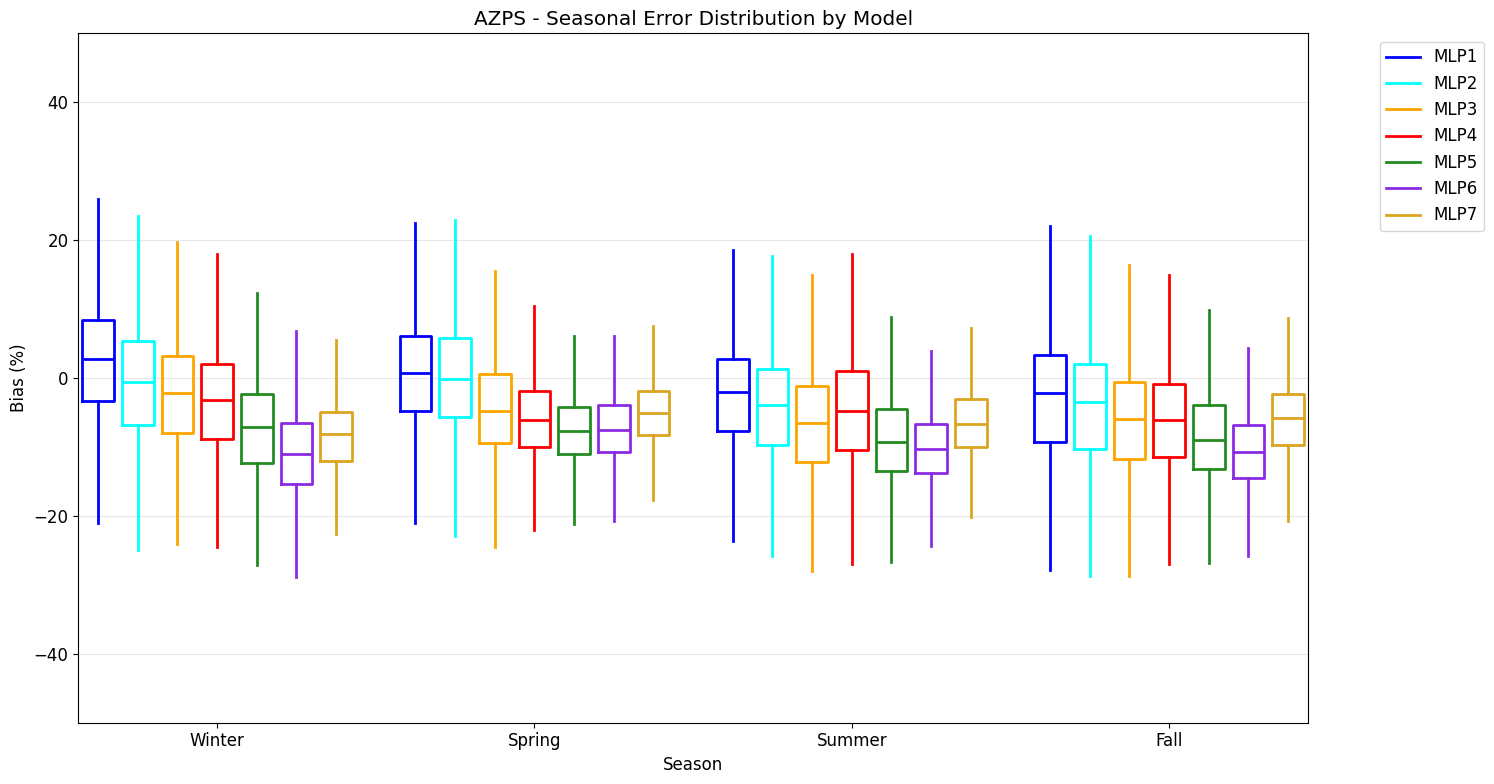

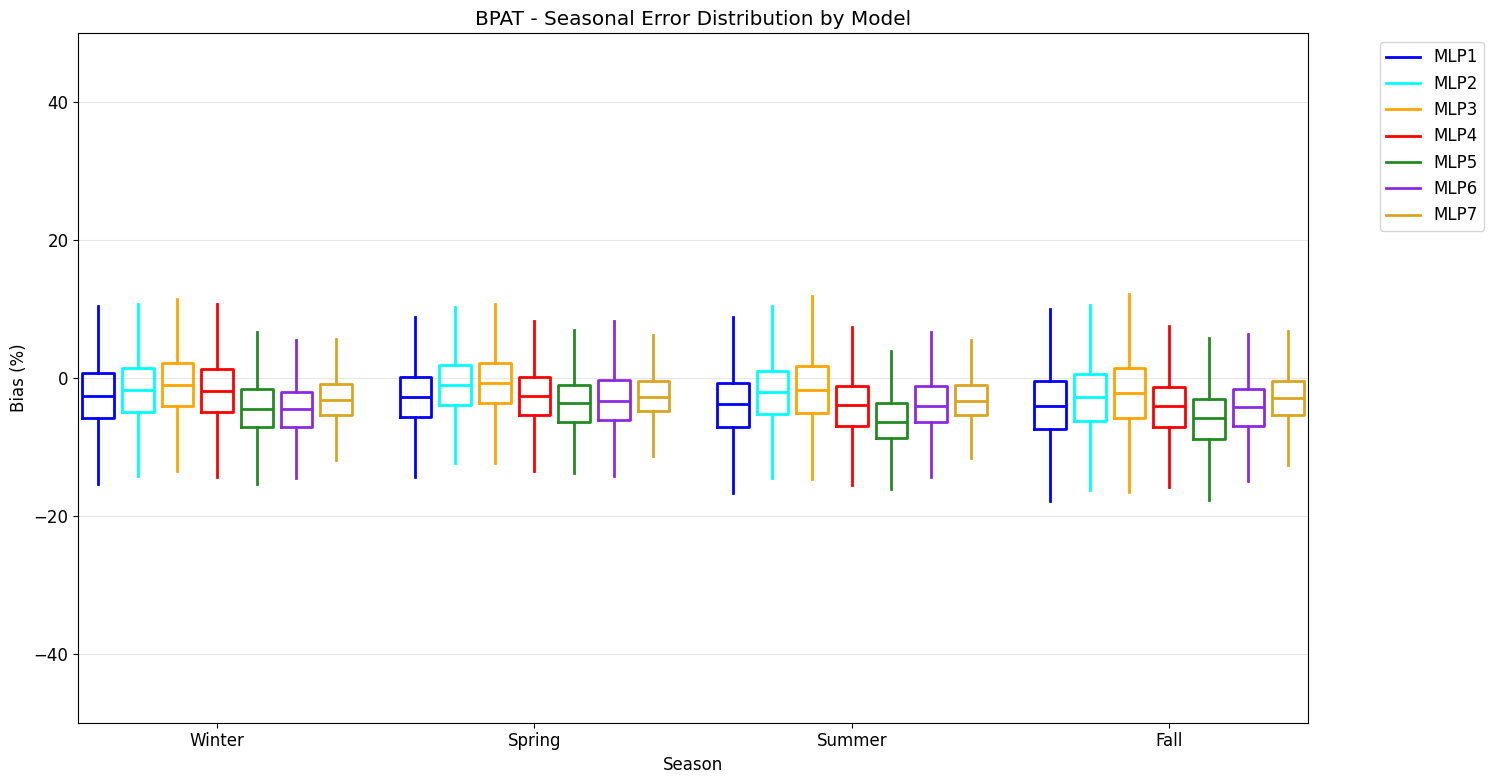

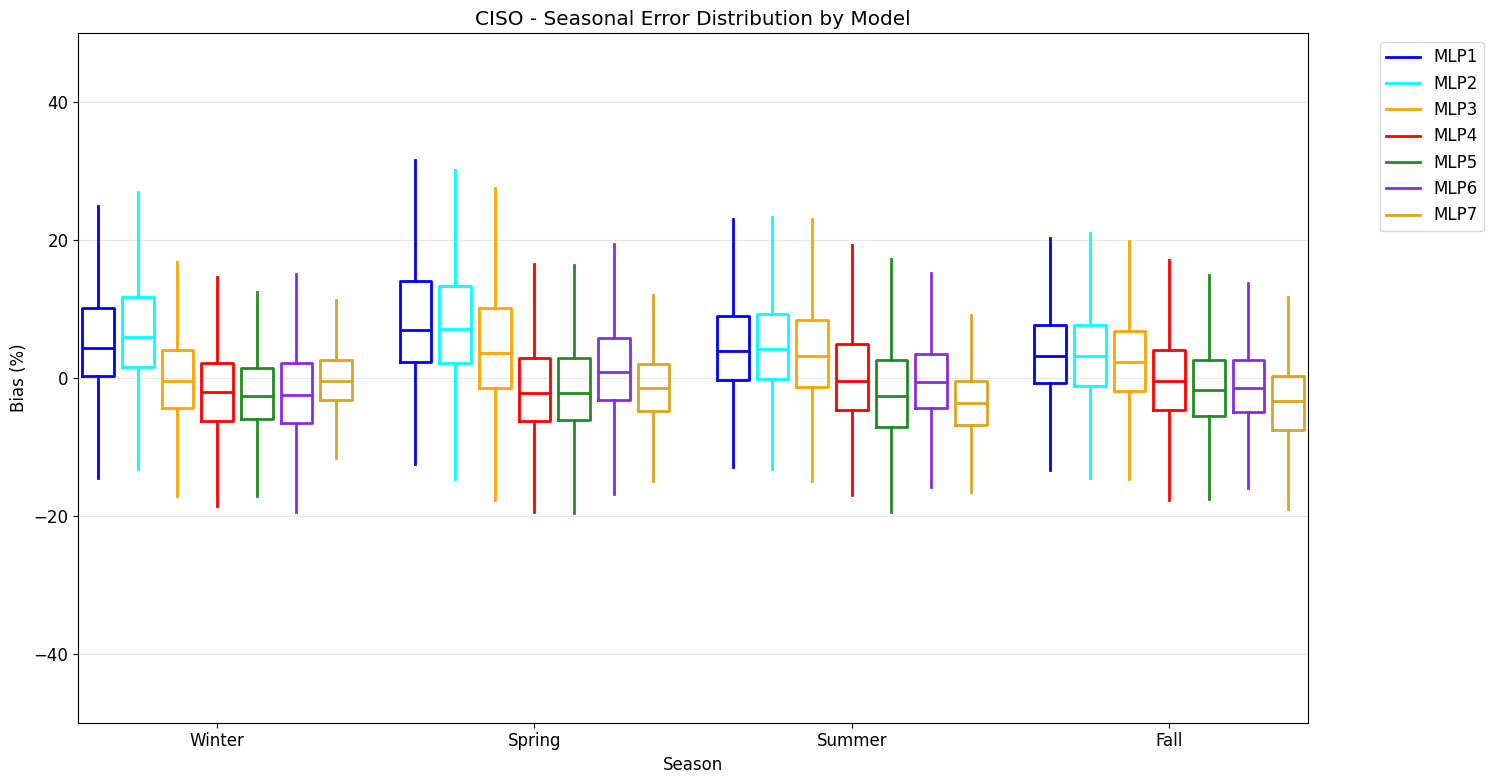

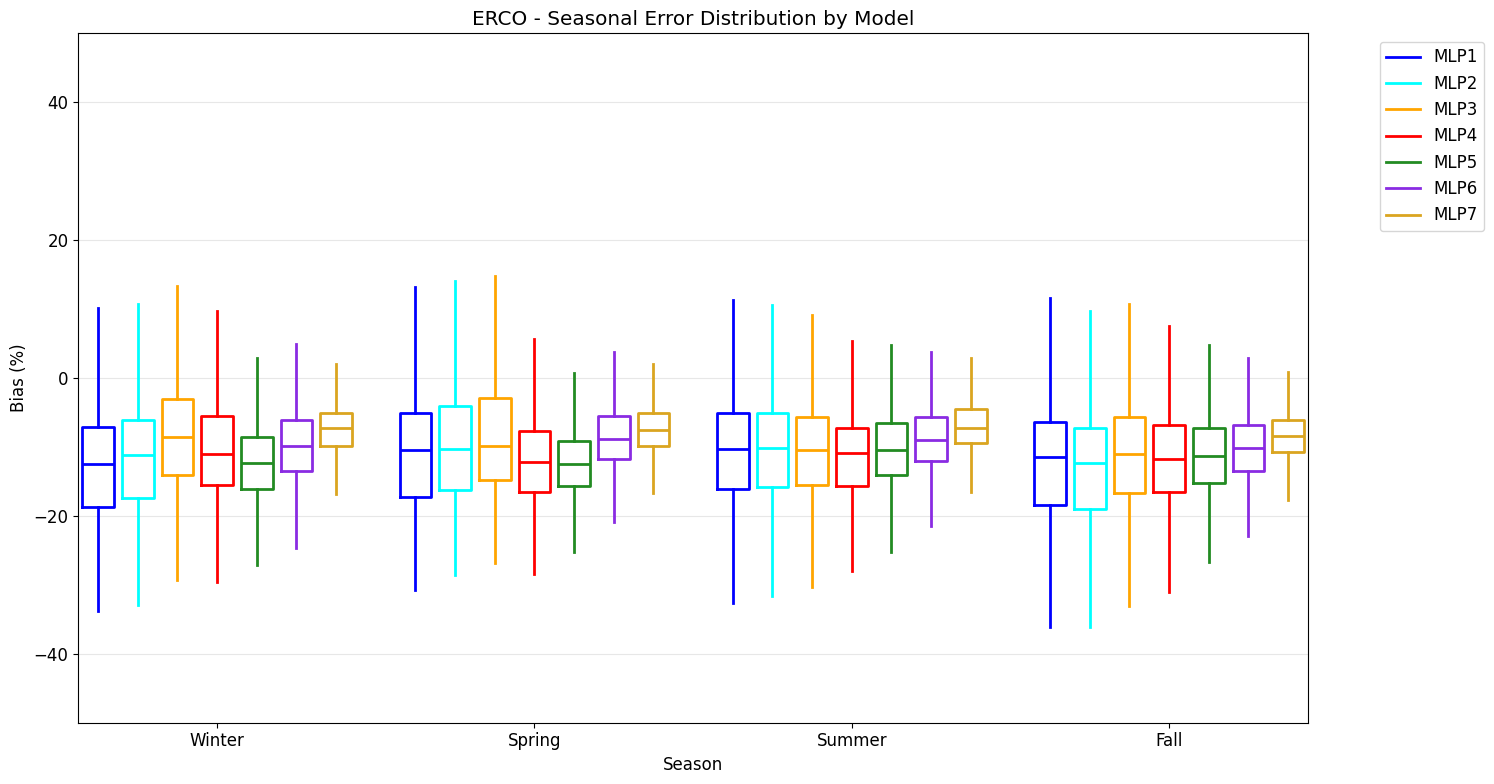

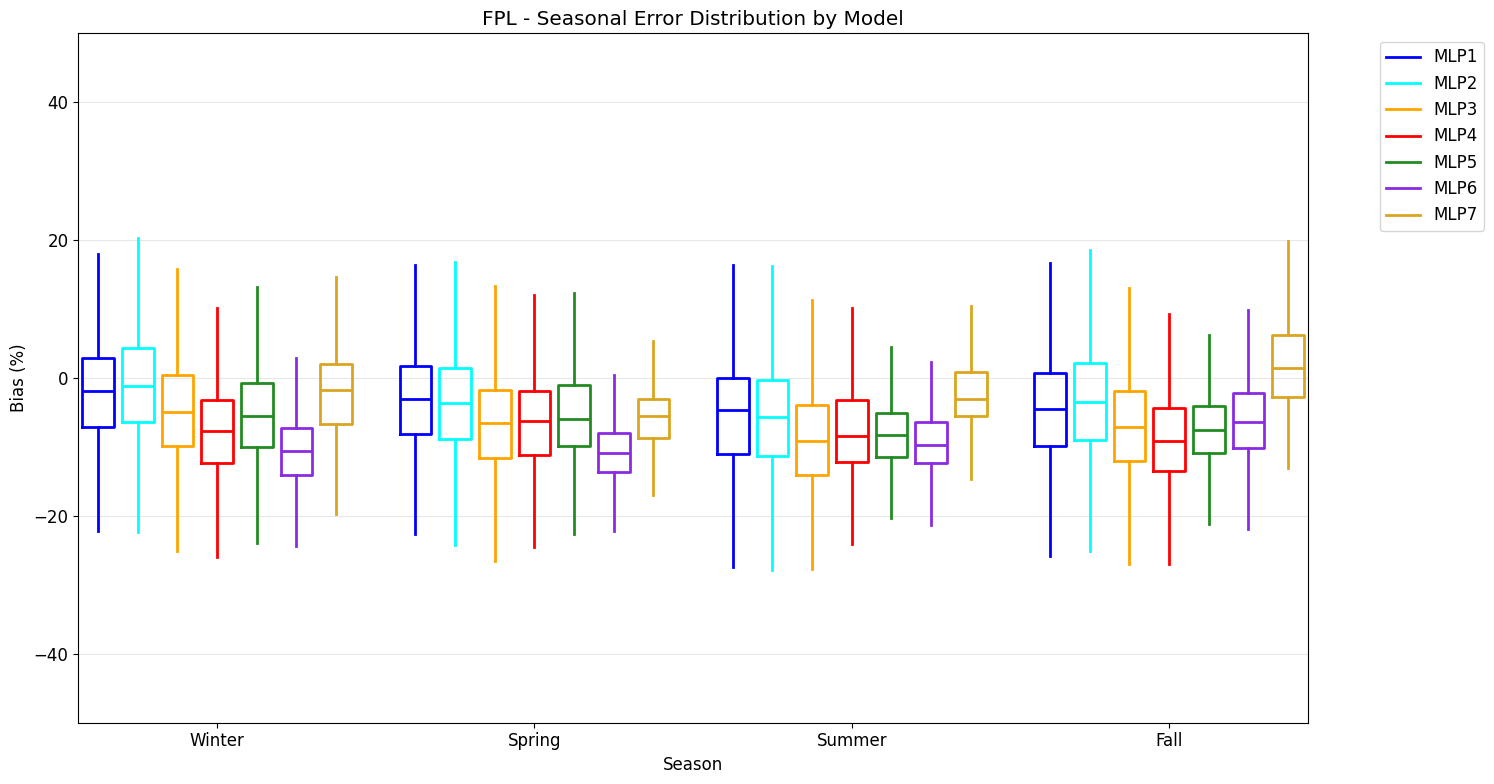

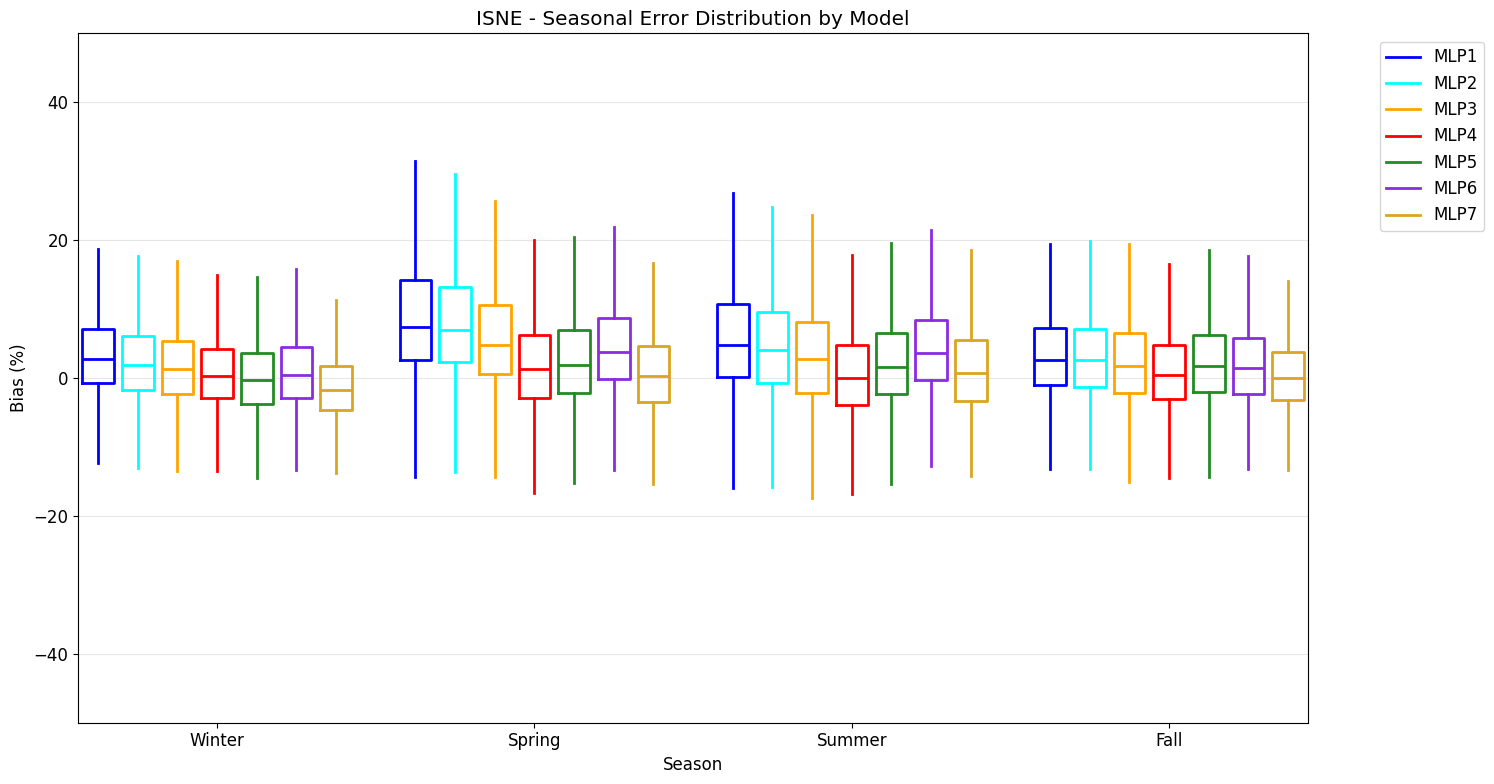

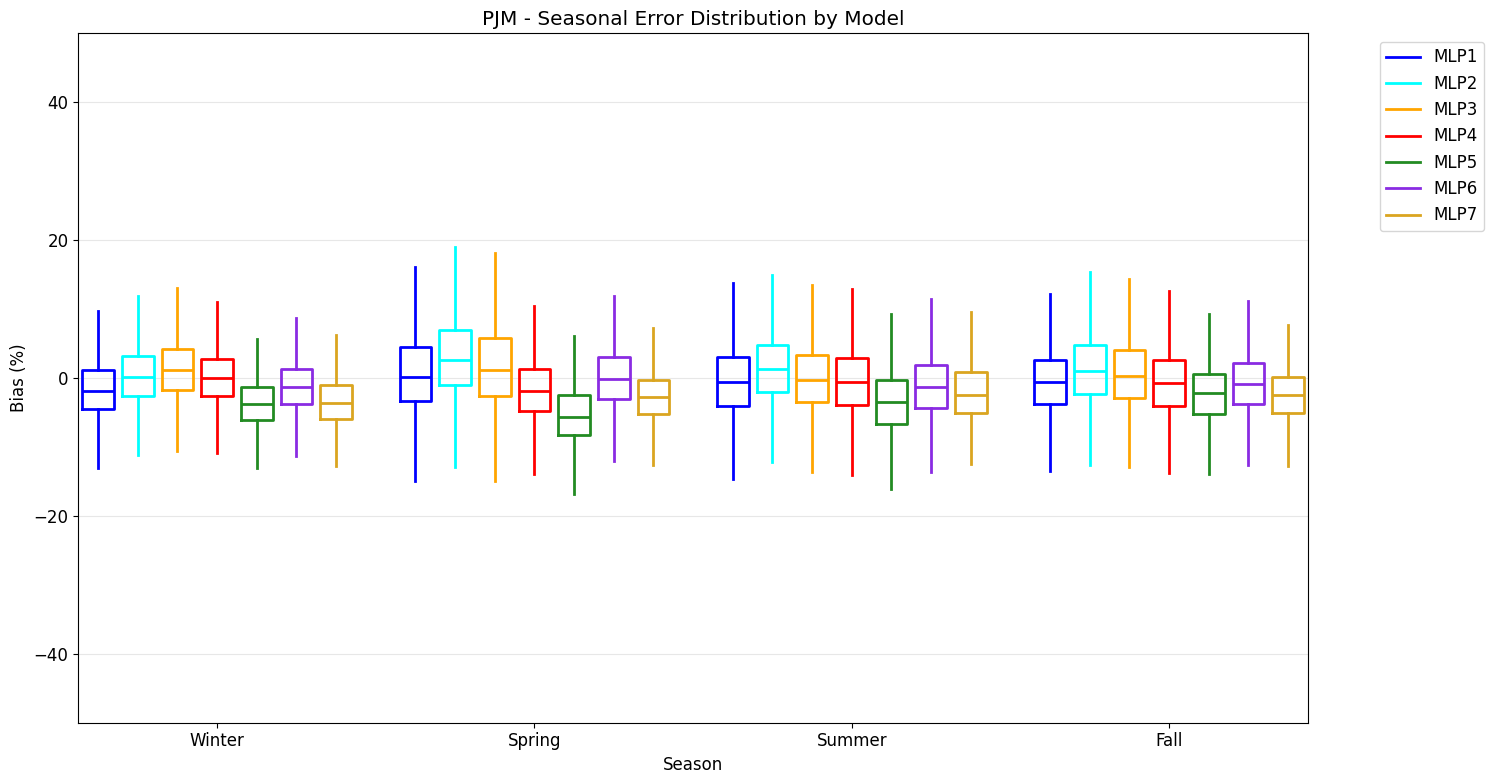

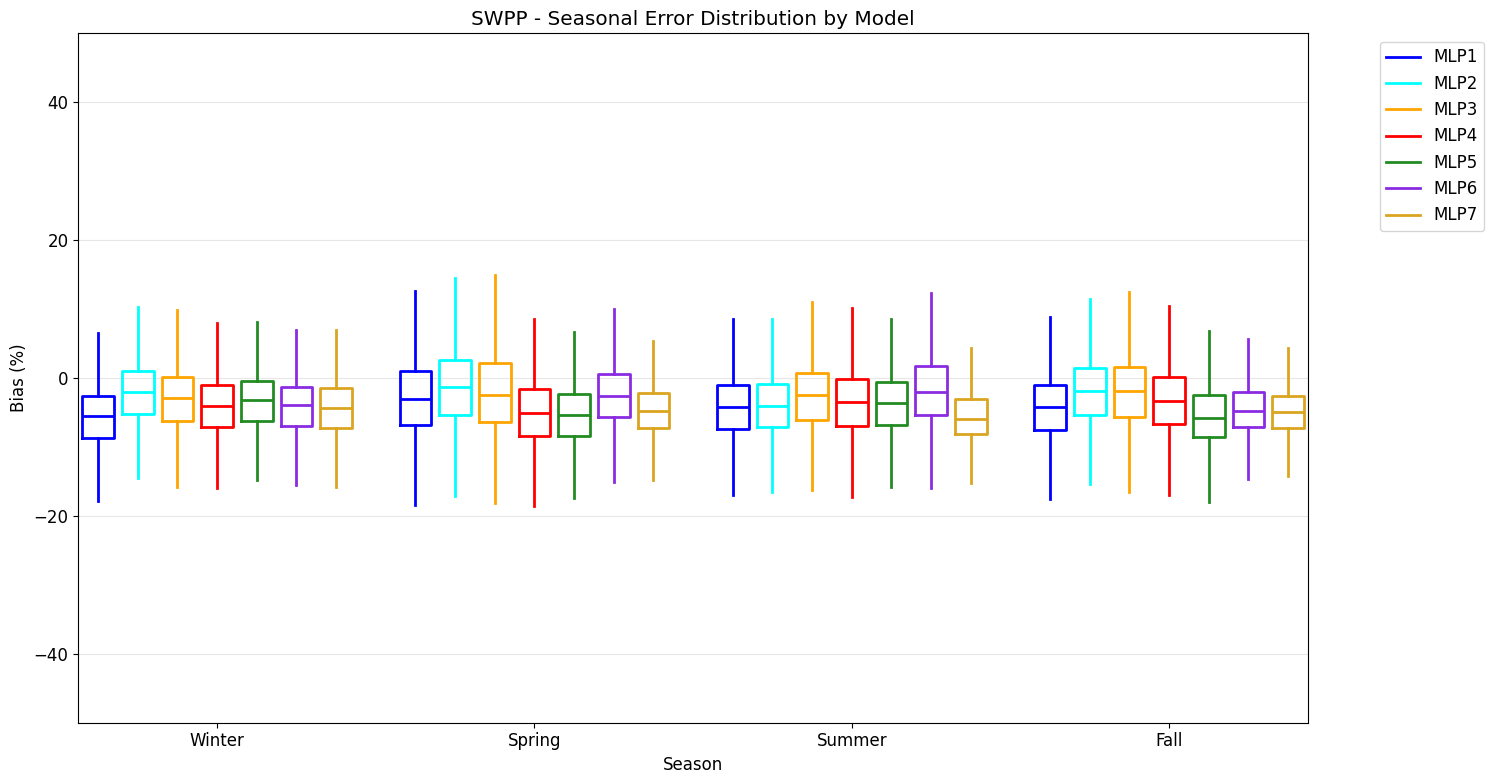

In [4]:
# Analyze seasonal error for each BA
for ba in bas:
    # Load the compiled dataset for each BA
    ba_df = pd.read_csv((composite_input_directory + ba + '_Composite_Data.csv'), index_col=None, header=0)
    ba_df['Time_UTC'] = pd.to_datetime(ba_df['Time_UTC'])
    ba_df['Month'] = ba_df['Time_UTC'].dt.month
    ba_df['Year'] = ba_df['Time_UTC'].dt.year
    ba_df['Season'] = pd.cut(
        ba_df['Month'],
        bins=[0, 3, 6, 9, 12],
        labels=['Winter', 'Spring', 'Summer', 'Fall'],
        include_lowest=True
    )
    
    # Define model start years
    model_start_years = {
        'MLP1': 2018, 'MLP2': 2019, 'MLP3': 2020, 'MLP4': 2021,
        'MLP5': 2022, 'MLP6': 2023, 'MLP7': 2024
    }
    
    # Calculate bias for each model
    model_seasonal_data = {}
    models = ['MLP1', 'MLP2', 'MLP3', 'MLP4', 'MLP5', 'MLP6', 'MLP7']
    for model in models:
        subset_df = ba_df[['Season', 'Year', 'Demand_MWh', (model + '_MWh')]].copy()
        # Filter data from model start year onwards
        subset_df = subset_df[subset_df['Year'] >= model_start_years[model]]
        # Exclude rows with -999 values instead of converting to NaN
        subset_df = subset_df[(subset_df['Demand_MWh'] != -999.0) & (subset_df[model + '_MWh'] != -999.0)]
        subset_df = subset_df.dropna()
        if len(subset_df) > 0:  # Only calculate if data exists
            subset_df['Bias_%'] = 100 * ((subset_df[model + '_MWh'] - subset_df['Demand_MWh']) / subset_df['Demand_MWh'])
            model_seasonal_data[model] = subset_df
    
    # Define style for each model
    colors = ['b', 'cyan', 'orange', 'r', 'forestgreen', 'blueviolet', 'goldenrod']
    model_styles = {}
    for i, model in enumerate(models):
        model_styles[model] = {
            'boxprops': dict(color=colors[i], linewidth=2),
            'medianprops': dict(color=colors[i], linewidth=2),
            'whiskerprops': dict(color=colors[i], linewidth=2),
            'flierprops': dict(color=colors[i], markeredgecolor=colors[i]),
            'capprops': dict(color=colors[i], linewidth=0)
        }
    
    # Define season order
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    
    # Create plot for each BA
    plt.figure(figsize=(15, 8))
    plt.rcParams['font.size'] = 12
    
    # Draw boxplot by model for each season
    legend_handles = []
    for season_idx, season in enumerate(season_order):
        base_position = season_idx * 8  # spacing between seasons
        for model_idx, model in enumerate(models):
            # Check if model has data for this analysis
            if model in model_seasonal_data:
                # Extract data for the corresponding season
                season_data = model_seasonal_data[model][model_seasonal_data[model]['Season'] == season]['Bias_%'].dropna()
                if len(season_data) > 0:
                    position = base_position + model_idx - 3  # -3 for center alignment
                    box = plt.boxplot(season_data,
                               positions=[position],
                               widths=0.8,
                               showfliers=False,  # remove outliers
                               **model_styles[model])
                    
                    # Add to legend handles only once per model
                    if season_idx == 0 and len(season_data) > 0:
                        legend_handles.append((colors[model_idx], model))
    
    # Create legend manually
    legend_lines = []
    legend_labels = []
    for color, label in legend_handles:
        line = plt.Line2D([0], [0], color=color, linewidth=2)
        legend_lines.append(line)
        legend_labels.append(label)
    
    # Plot settings
    plt.xticks([i*8 for i in range(4)], season_order)
    plt.xlabel('Season')
    plt.ylabel('Bias (%)')
    plt.title(f'{ba} - Seasonal Error Distribution by Model')
    if legend_lines:  # Only show legend if there are items
        plt.legend(legend_lines, legend_labels, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(-50, 50)  # fix y-axis range
    plt.tight_layout()
    plt.show()
    
    # Clean up memory
    del ba_df, model_seasonal_data

## Seasonal Error Comparison by Model for each BA / year

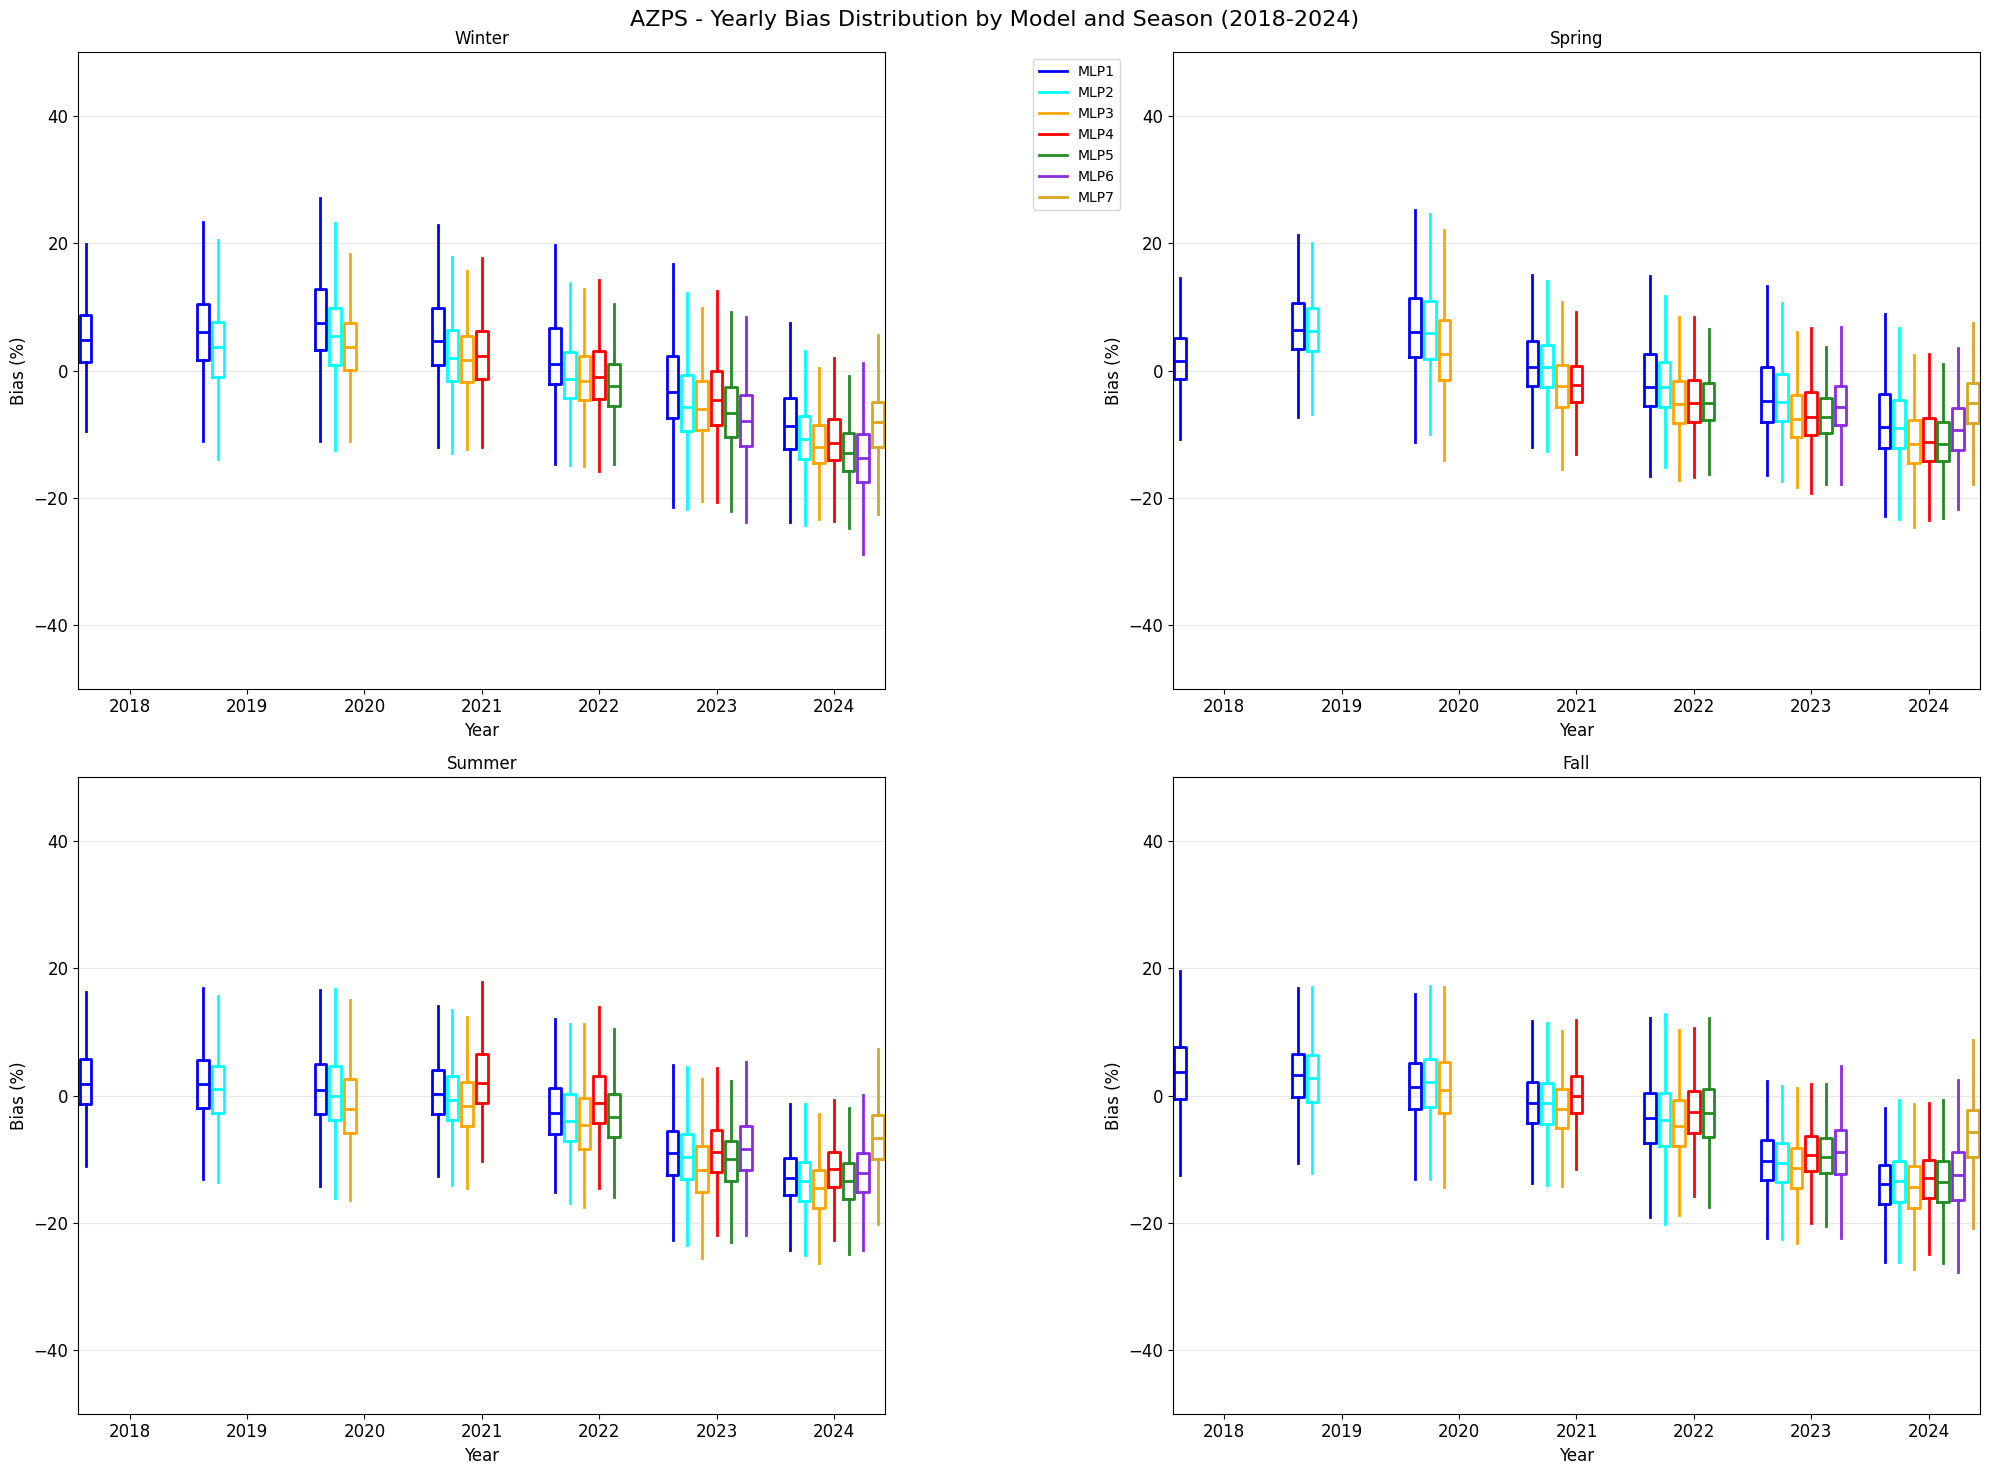

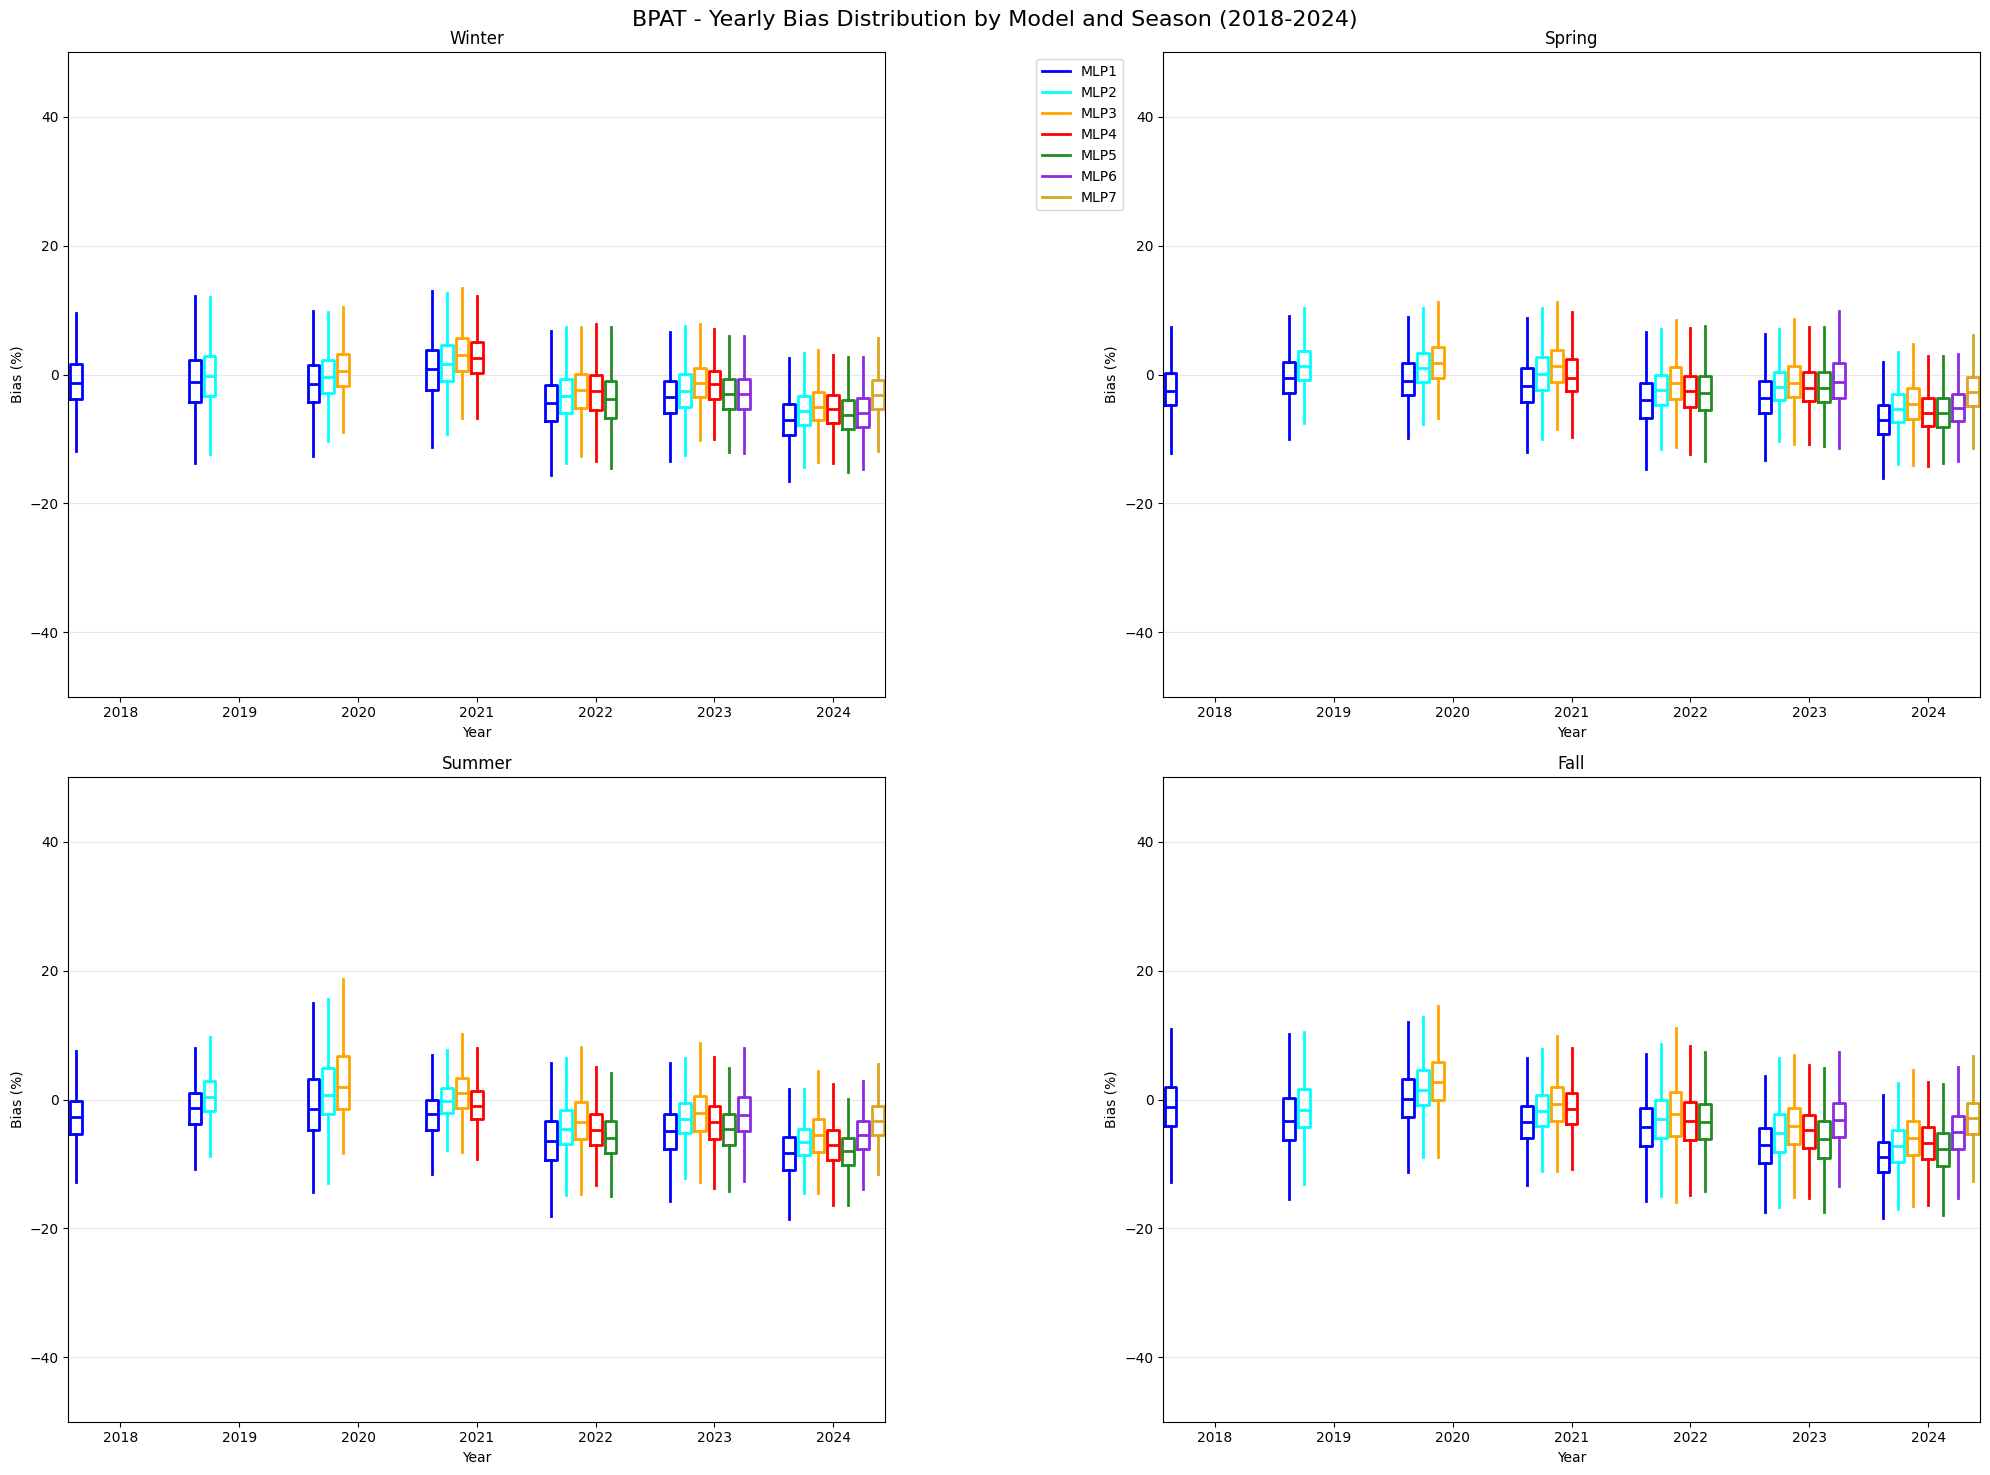

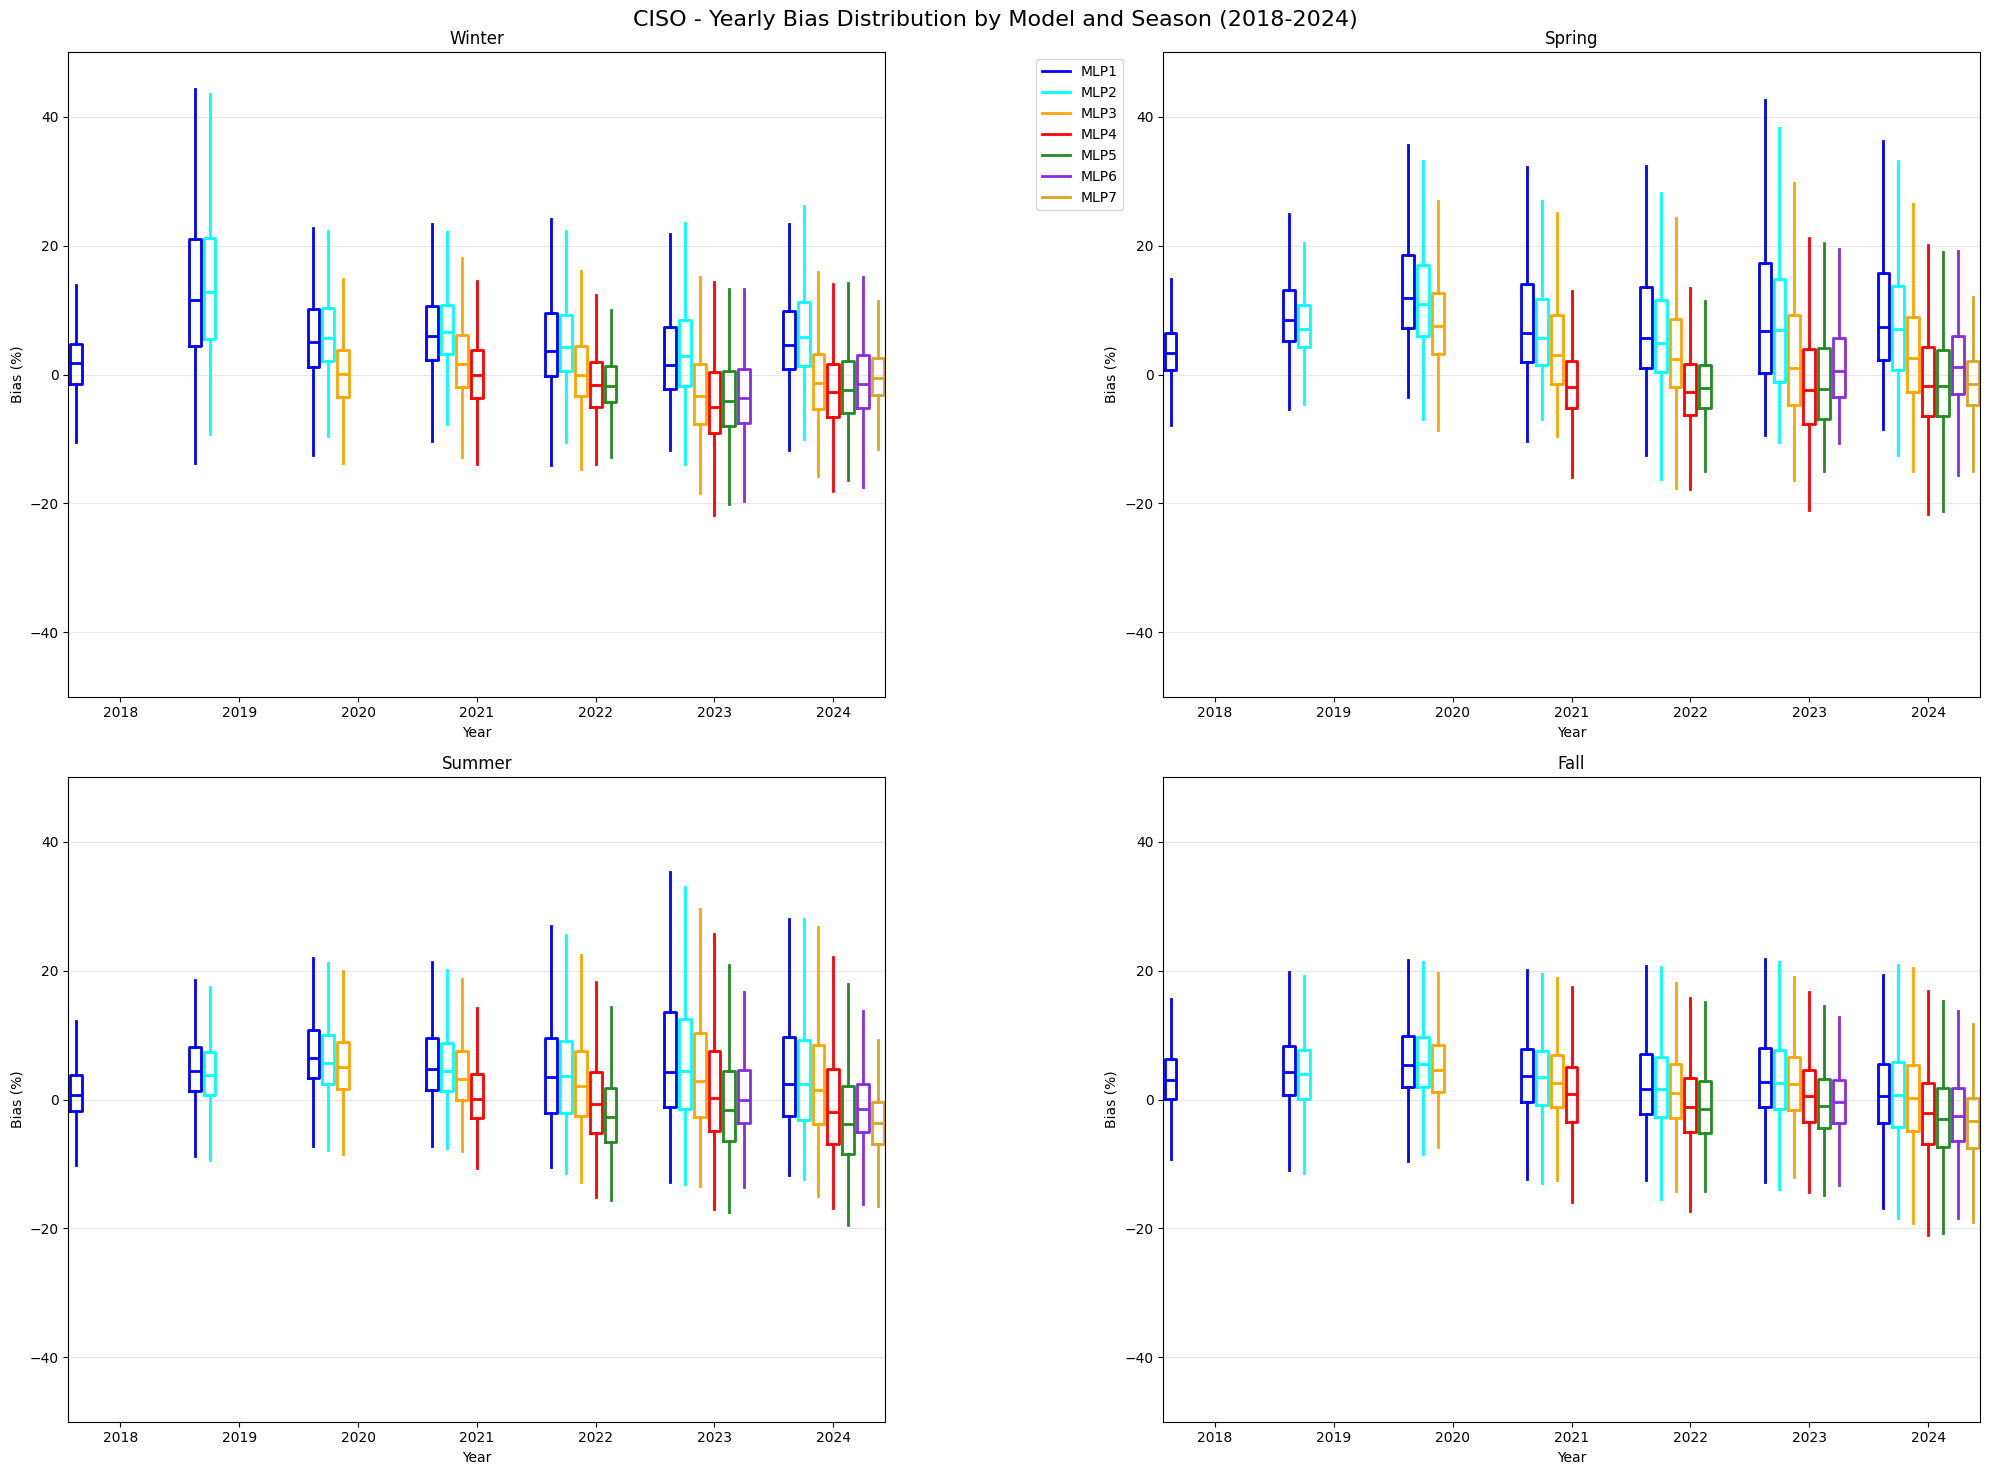

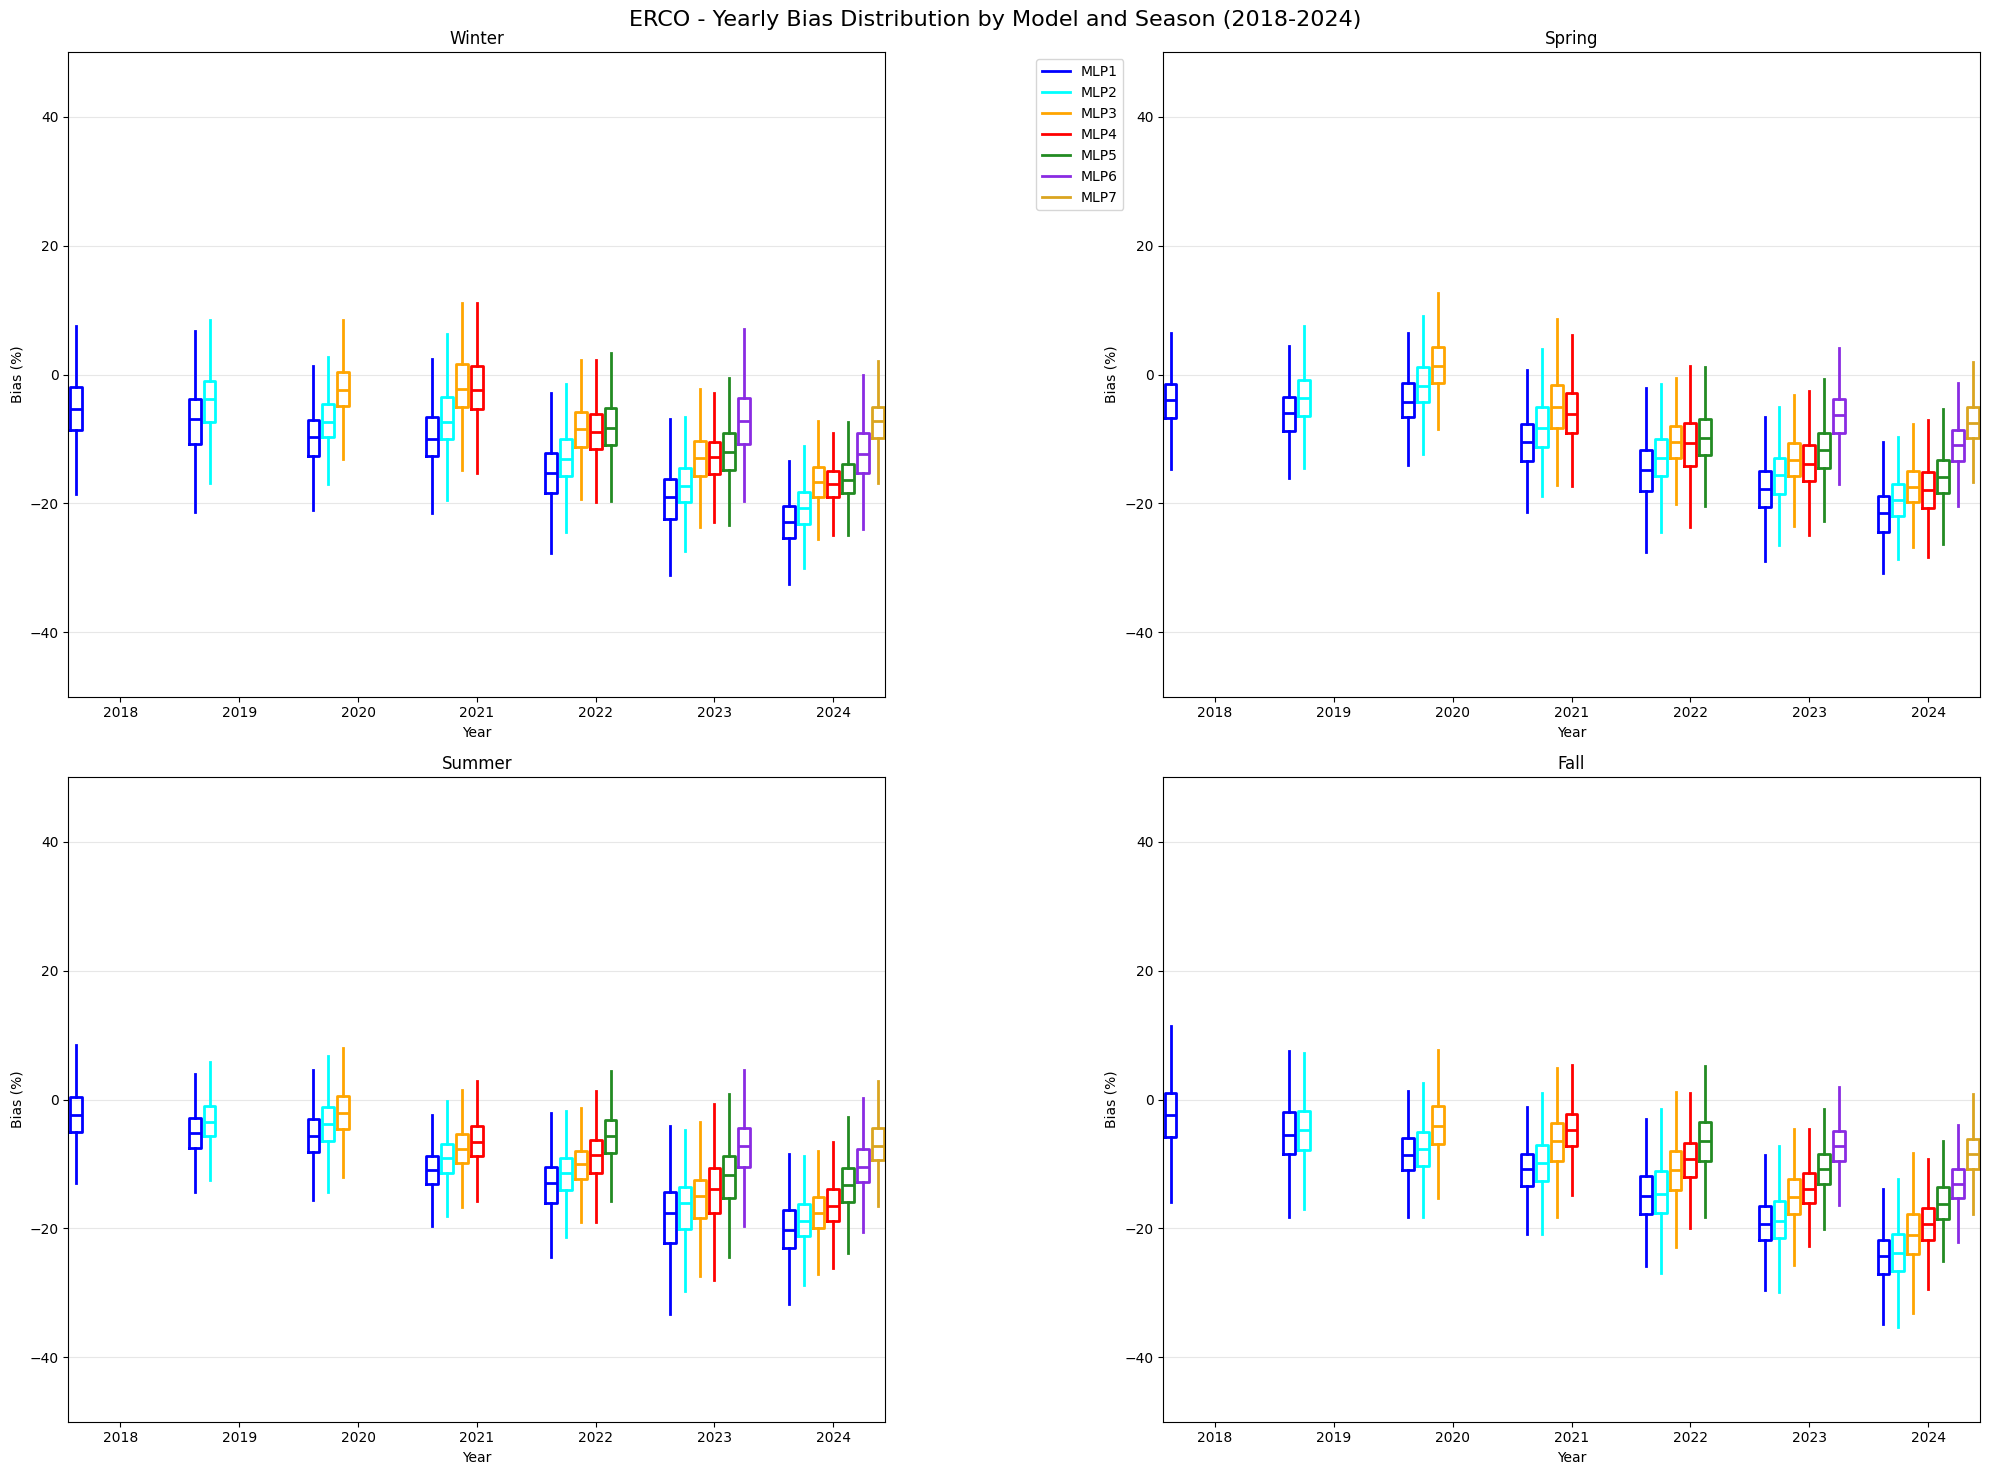

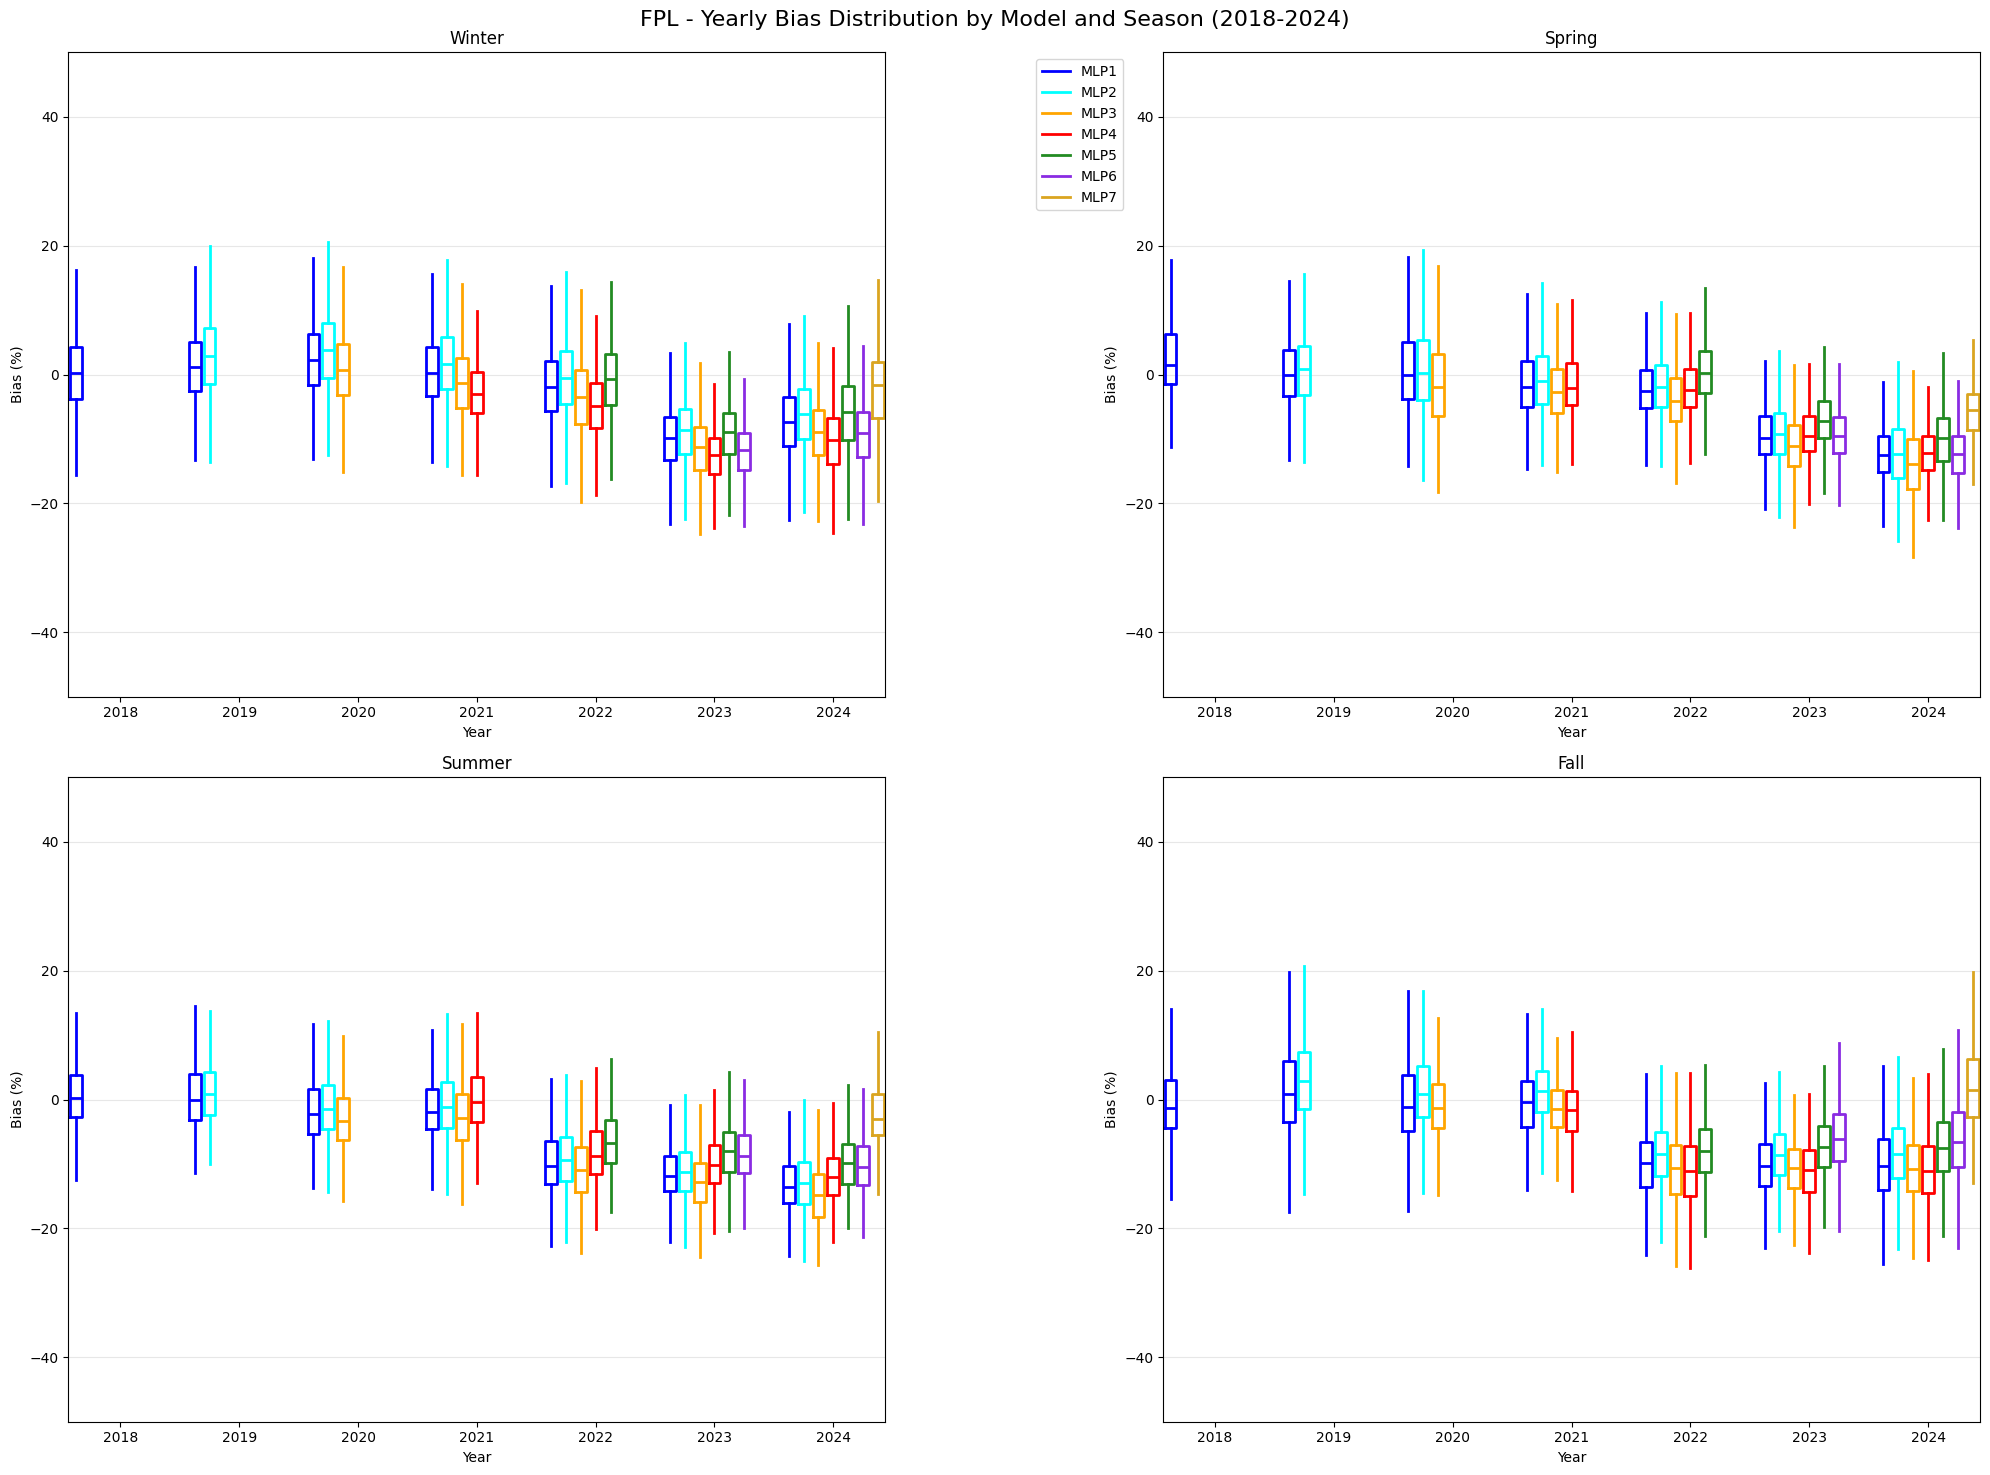

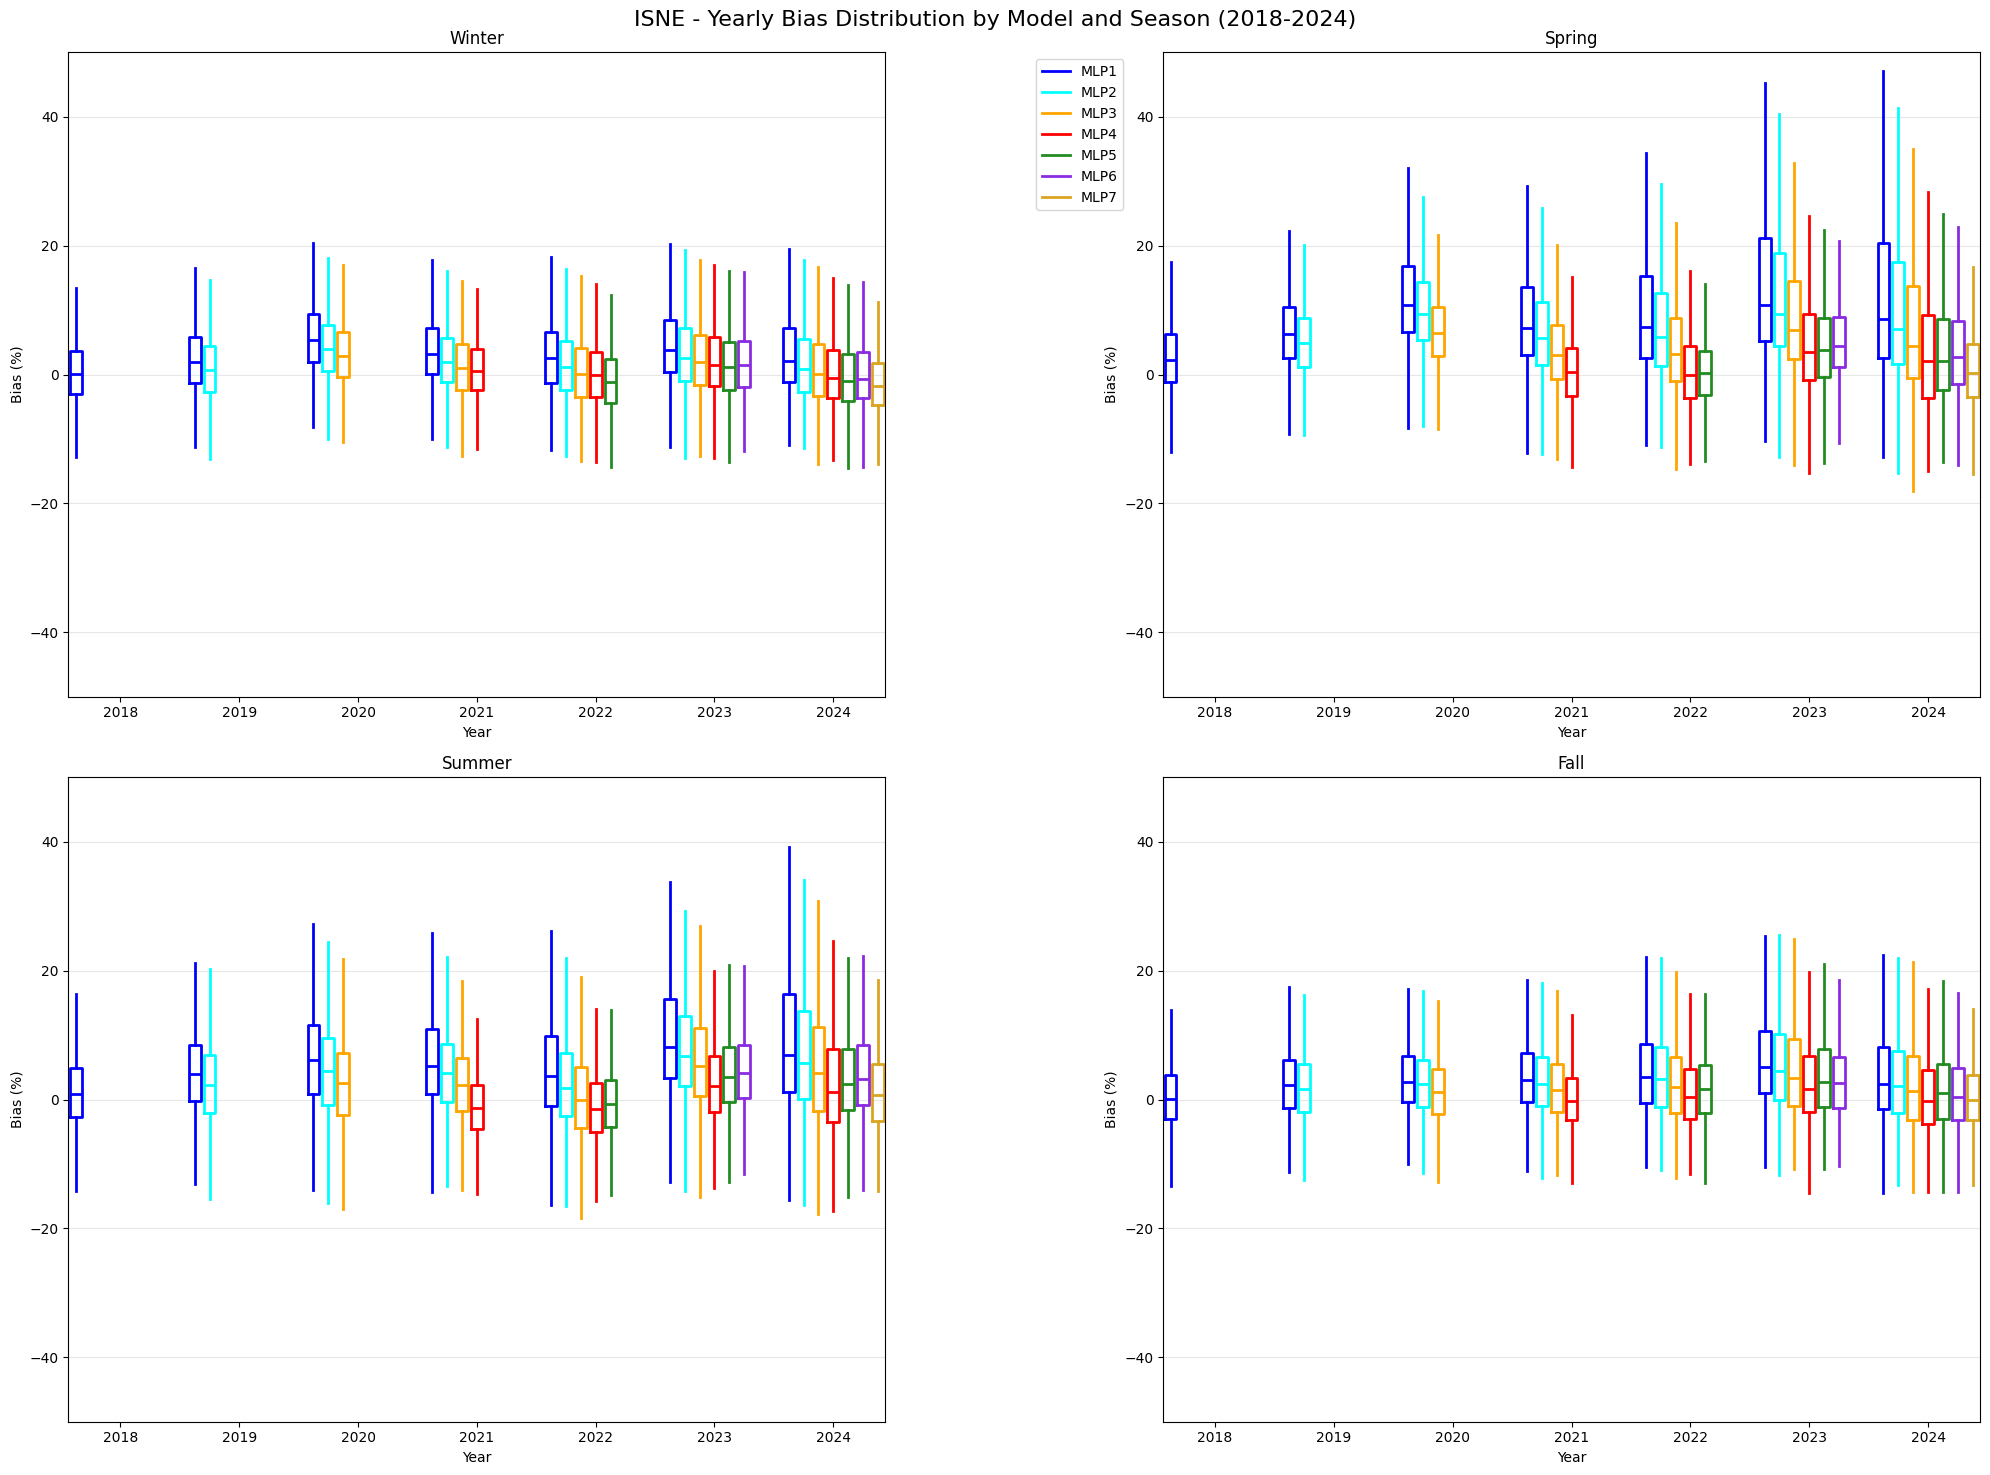

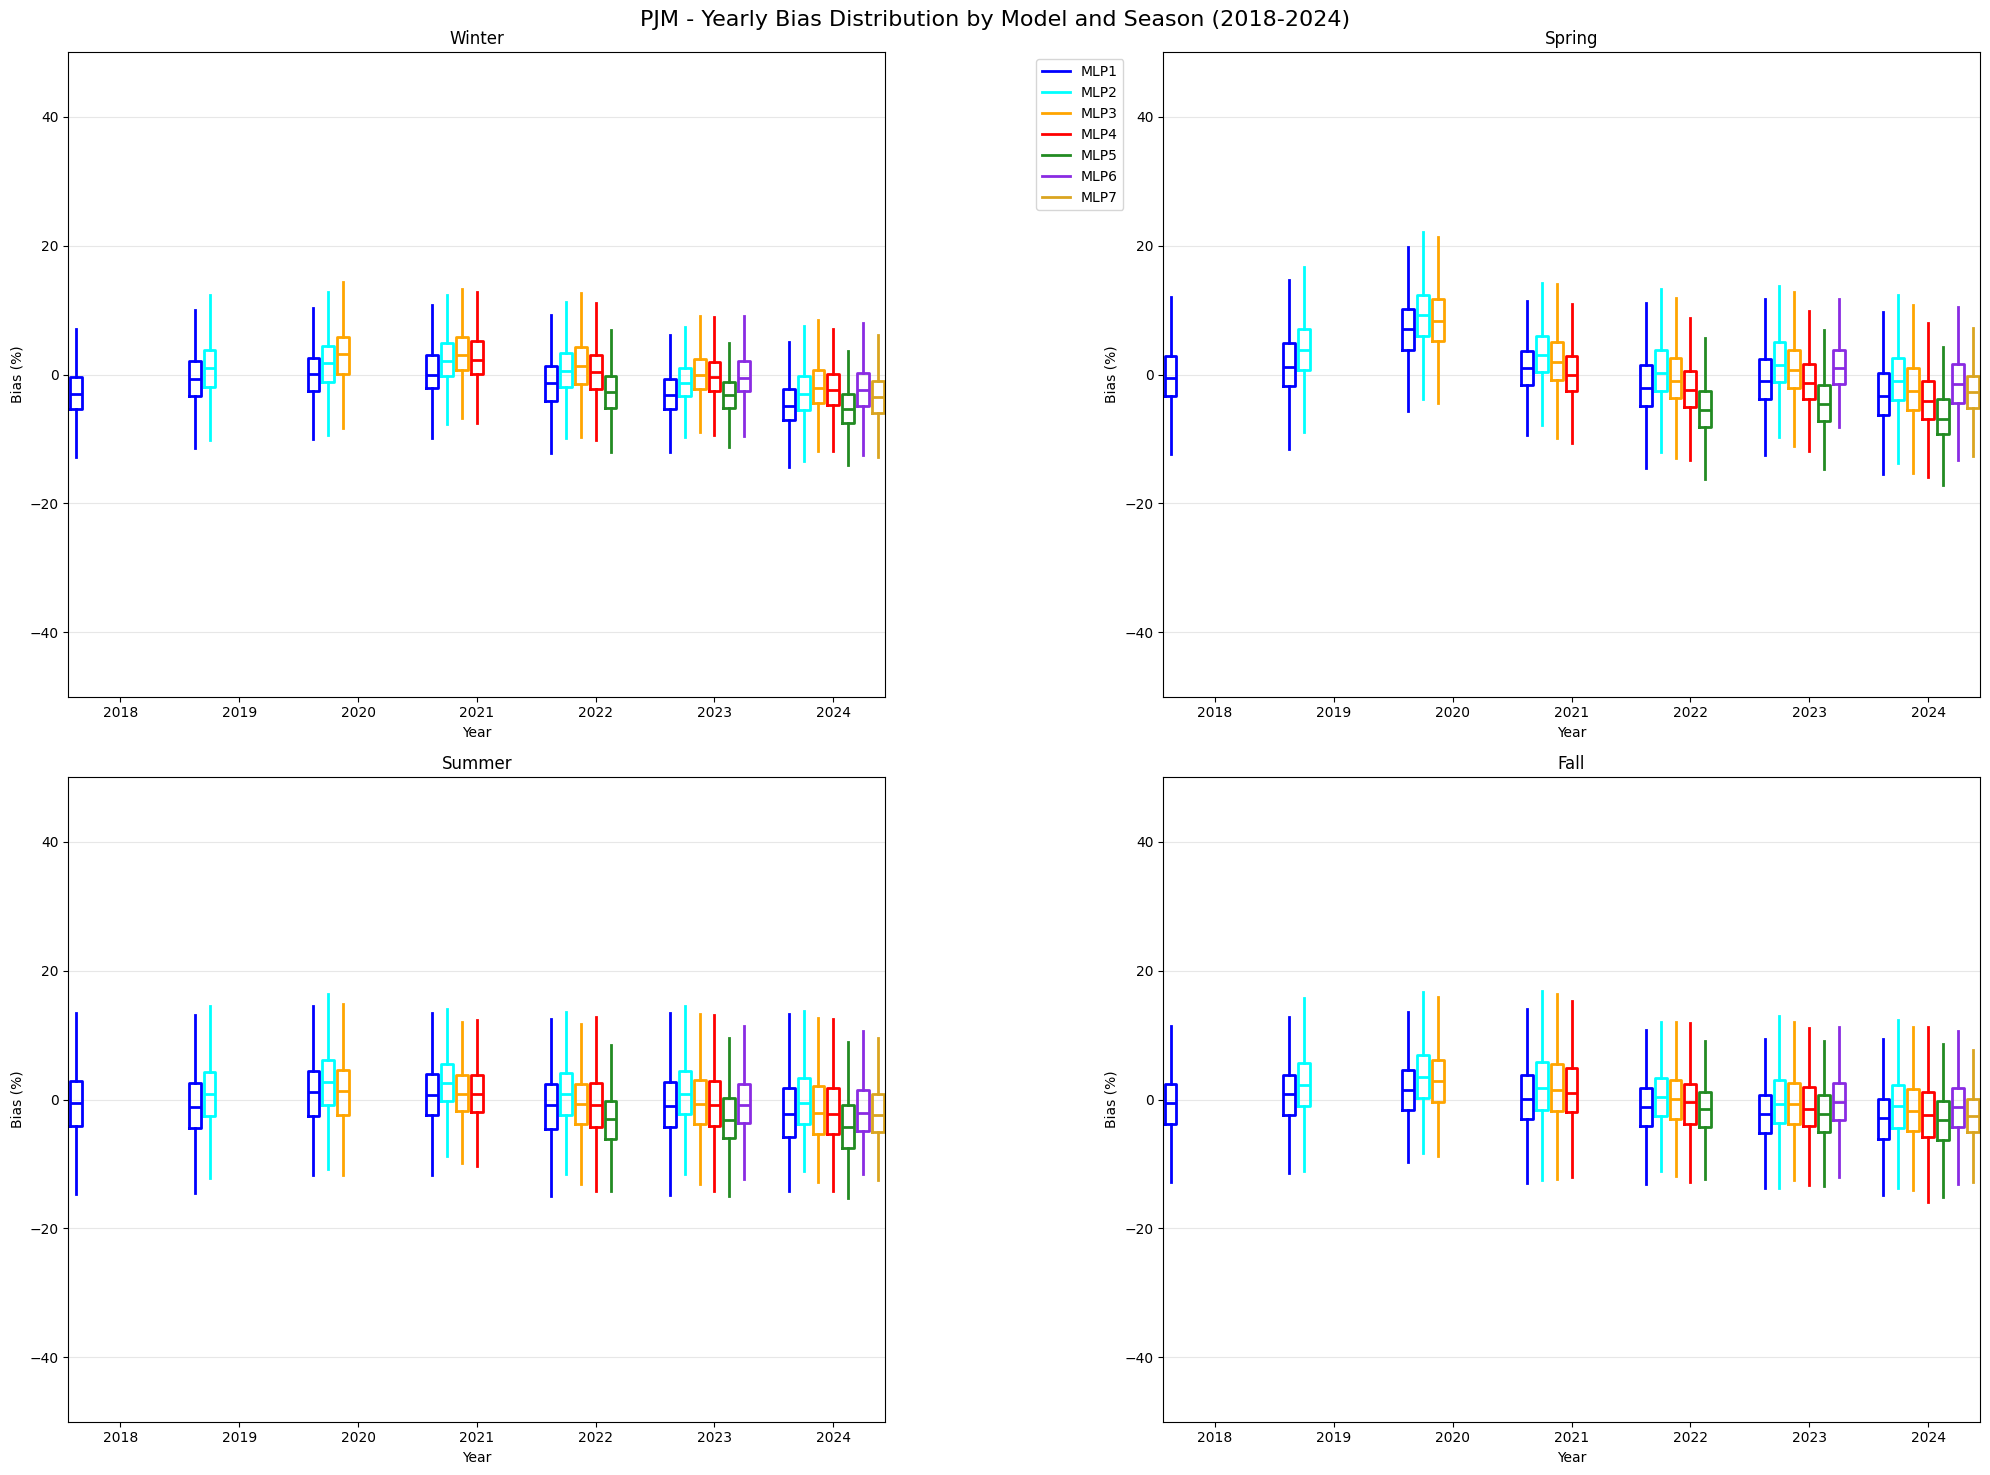

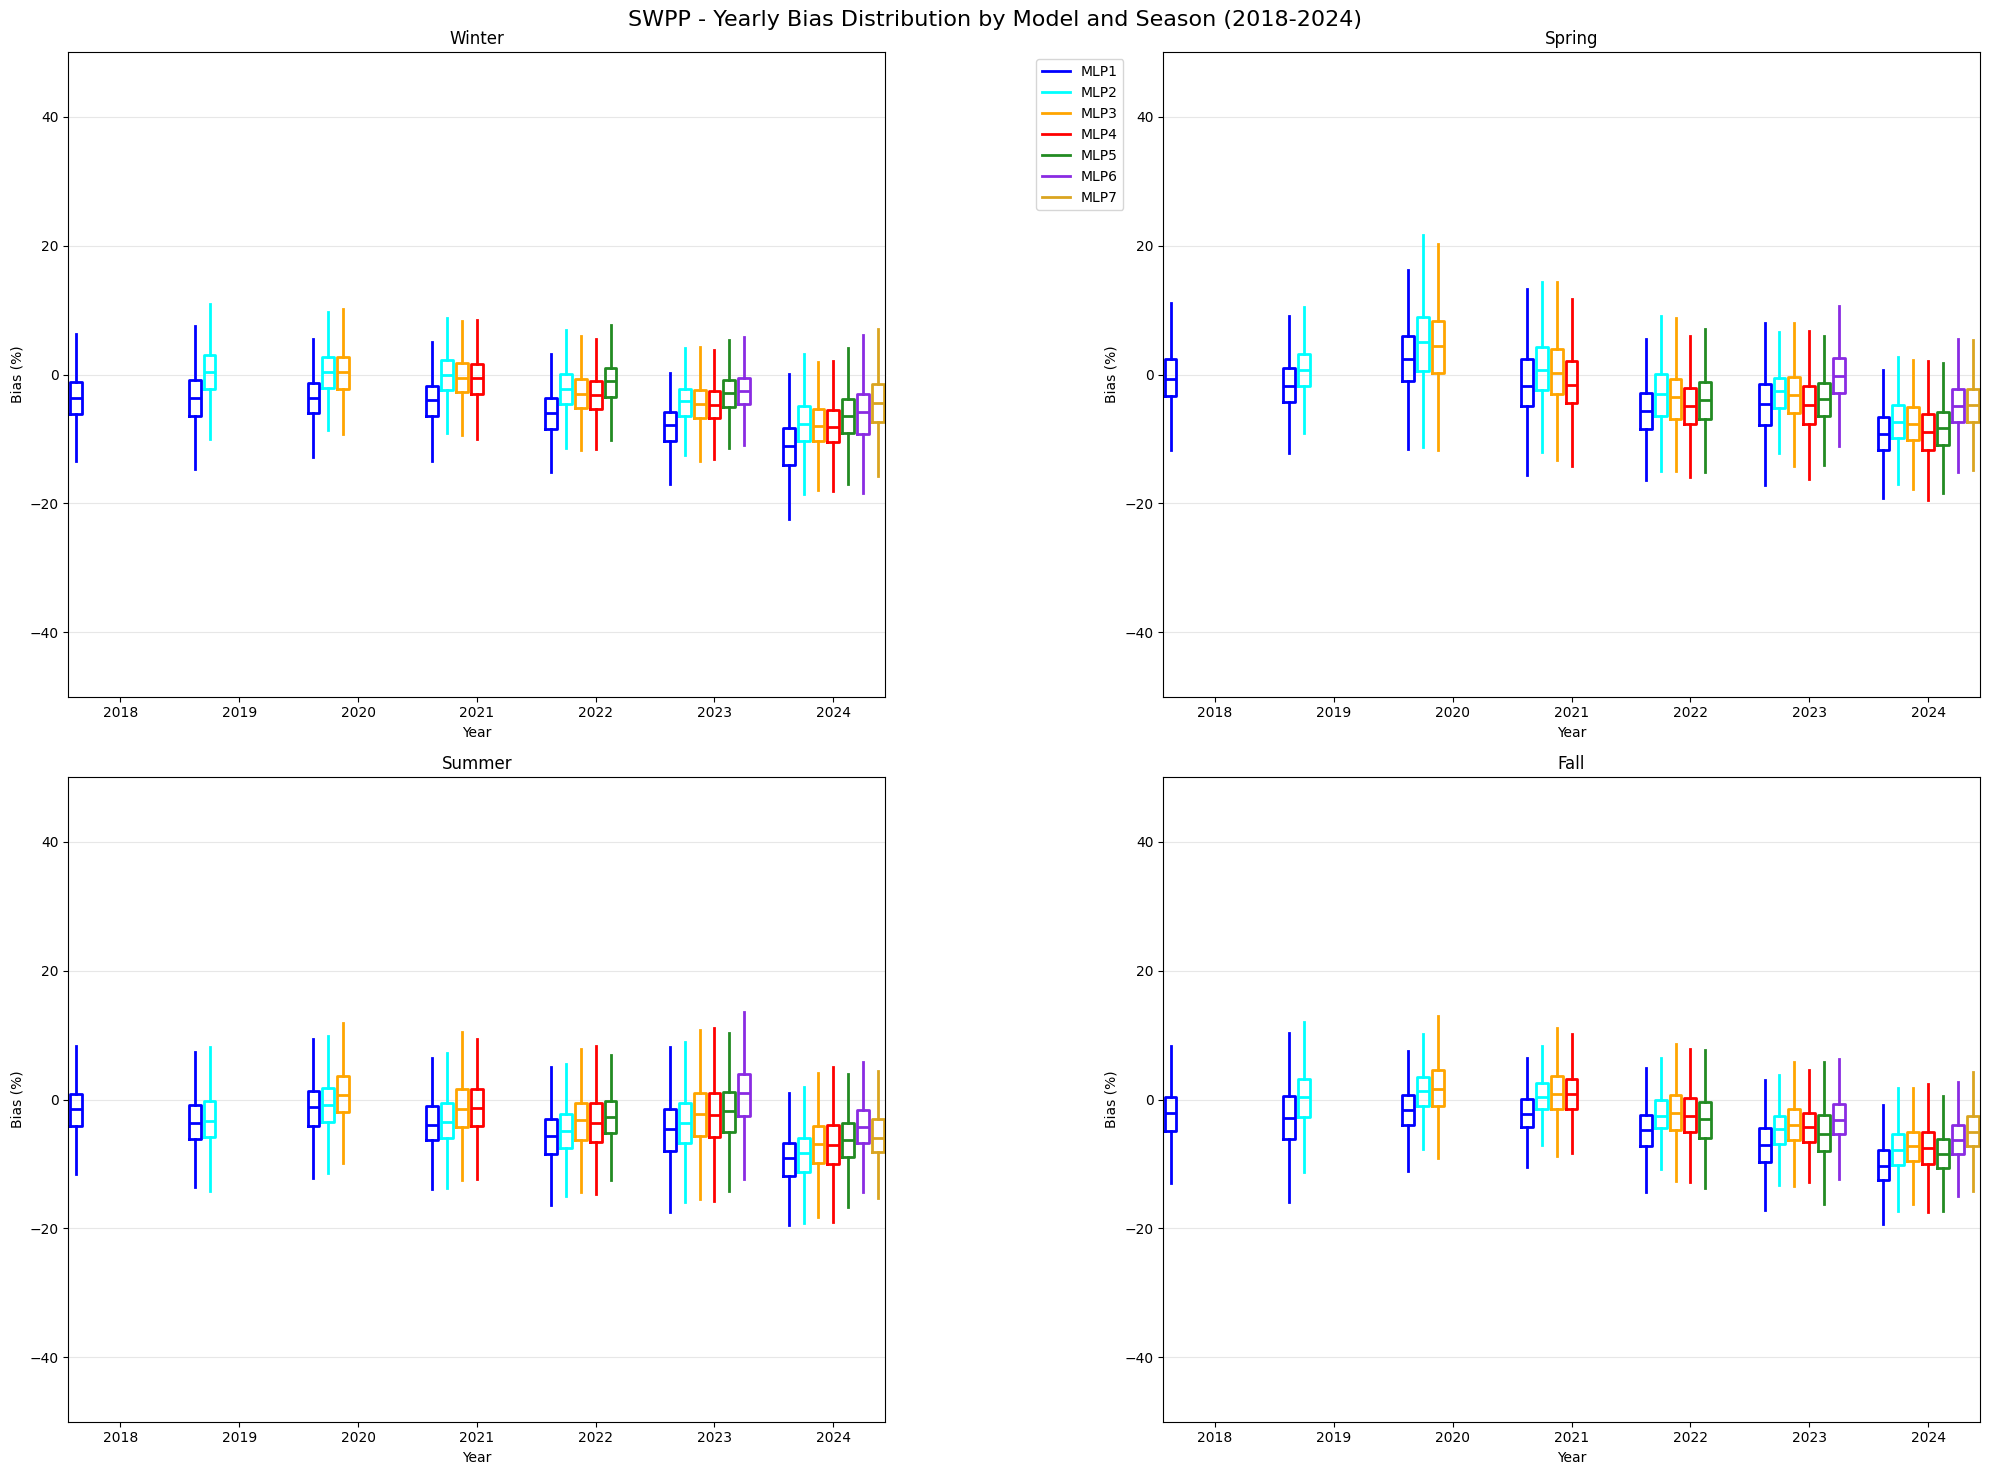

In [5]:
# Analyze for each BA
for ba in bas:
    # Load the compiled dataset for each BA
    ba_df = pd.read_csv((composite_input_directory + ba + '_Composite_Data.csv'), index_col=None, header=0)
    ba_df['Time_UTC'] = pd.to_datetime(ba_df['Time_UTC'])
    ba_df['Year'] = ba_df['Time_UTC'].dt.year
    ba_df['Month'] = ba_df['Time_UTC'].dt.month
    ba_df['Season'] = pd.cut(
        ba_df['Month'],
        bins=[0, 3, 6, 9, 12],
        labels=['Winter', 'Spring', 'Summer', 'Fall'],
        include_lowest=True
    )
    
    # Define model start years
    model_start_years = {
        'MLP1': 2018, 'MLP2': 2019, 'MLP3': 2020, 'MLP4': 2021,
        'MLP5': 2022, 'MLP6': 2023, 'MLP7': 2024
    }
    
    # Calculate bias for each model
    model_data = {}
    models = ['MLP1', 'MLP2', 'MLP3', 'MLP4', 'MLP5', 'MLP6', 'MLP7']
    for model in models:
        subset_df = ba_df[['Season', 'Year', 'Demand_MWh', (model + '_MWh')]].copy()
        # Filter data from model start year onwards
        subset_df = subset_df[subset_df['Year'] >= model_start_years[model]]
        # Exclude rows with -999 values instead of converting to NaN
        subset_df = subset_df[(subset_df['Demand_MWh'] != -999.0) & (subset_df[model + '_MWh'] != -999.0)]
        subset_df = subset_df.dropna()
        if len(subset_df) > 0:  # Only calculate if data exists
            subset_df['Bias_%'] = 100 * ((subset_df[model + '_MWh'] - subset_df['Demand_MWh']) / subset_df['Demand_MWh'])
            model_data[model] = subset_df
    
    # Define style for each model
    colors = ['b', 'cyan', 'orange', 'r', 'forestgreen', 'blueviolet', 'goldenrod']
    model_styles = {}
    for i, model in enumerate(models):
        model_styles[model] = {
            'boxprops': dict(color=colors[i], linewidth=2),
            'medianprops': dict(color=colors[i], linewidth=2),
            'whiskerprops': dict(color=colors[i], linewidth=2),
            'flierprops': dict(color=colors[i], markeredgecolor=colors[i]),
            'capprops': dict(color=colors[i], linewidth=0)
        }
    
    # Create subplots by season
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(f'{ba} - Yearly Bias Distribution by Model and Season (2018-2024)', fontsize=16)
    plt.rcParams['font.size'] = 10
    
    # Track legend items
    legend_created = False
    
    # Plot for each season
    for season_idx, season in enumerate(season_order):
        row = season_idx // 2
        col = season_idx % 2
        ax = axes[row, col]
        
        legend_handles = []
        
        # Draw boxplot by model for each year
        years = range(2018, 2025)
        for year_idx, year in enumerate(years):
            base_position = year_idx * 8  # spacing between years
            for model_idx, model in enumerate(models):
                # Only plot if the year is at or after the model's start year and model has data
                if year >= model_start_years[model] and model in model_data:
                    # Extract data for the corresponding season and year
                    season_year_data = model_data[model][
                        (model_data[model]['Season'] == season) &
                        (model_data[model]['Year'] == year)
                    ]['Bias_%'].dropna()
                    
                    if len(season_year_data) > 0:
                        position = base_position + model_idx - 3  # -3 for center alignment
                        ax.boxplot(season_year_data,
                                  positions=[position],
                                  widths=0.8,
                                  showfliers=False,  # remove outliers
                                  **model_styles[model])
                        
                        # Add to legend handles only once per model for first subplot
                        if season_idx == 0 and not legend_created:
                            if (colors[model_idx], model) not in legend_handles:
                                legend_handles.append((colors[model_idx], model))
        
        # Create legend for first subplot only
        if season_idx == 0 and not legend_created:
            legend_lines = []
            legend_labels = []
            for color, label in legend_handles:
                line = plt.Line2D([0], [0], color=color, linewidth=2)
                legend_lines.append(line)
                legend_labels.append(label)
            
            if legend_lines:  # Only show legend if there are items
                ax.legend(legend_lines, legend_labels, loc='upper right', bbox_to_anchor=(1.3, 1))
            legend_created = True
        
        # Subplot settings
        ax.set_xticks([i*8 for i in range(len(years))])
        ax.set_xticklabels(years)
        ax.set_xlabel('Year')
        ax.set_ylabel('Bias (%)')
        ax.set_title(f'{season}')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(-50, 50)  # fix y-axis range
    
    plt.tight_layout()
    plt.show()
    
    # Clean up memory
    del ba_df, model_data